# Prevendo o valor de jogadores de futebol usando suas estatísticas do Fifa
**Este trabalho faz parte do projeto de Machine Learning desenvolvido para a disciplina C318 do Instituto Nacional de Telecomunicações.**

**Data: 03 de junho de 2024**

<img src="recursos/fifa_img.png" style="height:400px;width:800px">
<br>

### Introdução
Perguntas que nos motivaram a realizar esse projeto:

**É possível prever o valor de um jogador de futebol a partir de seus atributos de jogo e meta dados?**  
**Quais fatores são mais importantes para determinar o valor de mercado de um jogador?**  
**Quais jogadores estão supervalorizados ou subvalorizados em comparação com o mercado?**

Neste notebook, vamos usar um conjunto de dados de atributos de jogadores extraídos do site oficial do jogo FIFA, [www.sofifa.com](www.sofifa.com), para responder às três perguntas acima\*. Embora fatores como forma física do jogador e resultados da equipe possam ter um impacto de curto prazo no valor percebido de um jogador, em última análise, o valor de um jogador deve estar vinculado às suas habilidades e atributos fundamentais - quão boas são suas habilidades em comparação com outras? Ser capaz de prever o valor de cada jogador e entender os principais motores das previsões tem dois benefícios principais:

1. Equipes de futebol/olheiros podem identificar se um jogador alvo está atualmente supervalorizado ou subvalorizado e qual preço devem estar dispostos a pagar por um jogador dessa qualidade (independentemente da forma atual).
2. Entender quais fatores mais afetam o valor pode informar jogadores em crescimento quais habilidades são mais demandadas no mercado e quais habilidades eles devem focar em melhorar para aumentar seu valor.

Para esta análise, realizarei uma análise exploratória de dados básica para obter uma visão geral dos recursos no conjunto de dados, antes de preparar os dados para modelagem (limpeza de dados; divisão treino/teste; escalonamento, etc.) e avaliar diferentes modelos de regressão para prever o valor dos jogadores de futebol no conjunto de dados.

\*Nota: O crawler scrapy para coletar os dados, scripts para limpar os dados e o conjunto de dados processado para análise estão localizados nas pastas **data_collection** e **data** no repositório.

### Premissas da Análise
Premissas principais para esta análise:
- o valor dos jogadores de futebol está correlacionado ao seu conjunto de habilidades, habilidades e meta dados
- o valor do jogador não é substancialmente impulsionado pela forma/desempenho de curto prazo (por exemplo, número de gols marcados ou jogos sem sofrer gols nos últimos 10 jogos, etc.)
- os valores dos jogadores são consistentes/transferíveis entre diferentes ligas/países. Ou seja, o valor de cada jogador não depende da liga na qual ele joga atualmente
- outros fatores 'comerciais', como presença na mídia/popularidade, não afetam o valor do jogador

## Resumo 

As pontuações de atributos dos jogadores (por exemplo, passe, precisão, resistência, aceleração, etc.) e informações adicionais (por exemplo, idade, posição, potencial, etc.) foram coletadas do site SoFIFA para a temporada de 2024. Essas informações foram usadas para desenvolver um modelo para prever o valor de cada jogador. A distribuição dos valores de mercado dos jogadores é muito positivamente enviesada, com a maioria dos jogadores tendo avaliações relativamente baixas, mas com alguns jogadores excepcionais comandando um prêmio significativo. Esta variável foi transformada logaritmicamente para normalizar os dados e criar a variável alvo para modelagem - log(valor).

Inicialmente, seis modelos de regressão foram testados no conjunto completo de características (regressão linear, regressão linear múltipla, Decision trees, Random forests e XGBoost) usando GridSearchCV para ajustar os hiperparâmetros. O XGBoost teve o melhor desempenho com um erro quadrático médio (RMSE) de 0,18. Após interpretar a saída do modelo, os atributos individuais de jogo foram considerados estatisticamente significativos, mas não economicamente significativos. Os atributos de jogo foram combinados em categorias mais gerais para reduzir a complexidade do modelo, mas preservar algumas das informações contidas nesses recursos. Usando o algoritmo XGBoost no novo conjunto de recursos, o desempenho do modelo foi marginalmente melhor, resultando em um RMSE de 0,17.

Os valores SHAP foram usados para interpretar o modelo XGBoost, com a classificação geral, potencial do jogador e idade sendo os recursos mais importantes. A idade teve uma relação não linear com a variável alvo, com jogadores mais velhos tendo um valor de mercado previsto significativamente menor. Das características de habilidades, habilidades de ataque (cruzamento, finalização, passe curto, etc.) foram as mais importantes para aumentar o valor previsto.

O modelo foi usado para identificar jogadores ingleses subvalorizados e supervalorizados. Os jogadores supervalorizados incluíam nomes famosos e/ou jogadores que jogaram para grandes clubes no passado. Isso sugere que popularidade/reputação, que não foi incluída como um recurso, pode inflar o valor dos jogadores além de sua habilidade fundamental.

------------------------

# Conteúdo

**[1. Análise Exploratória de Dados](#eda)**  
**[2. Modelagem](#modeling)**  
**&nbsp;&nbsp;[2.1 Preparação de Dados](#data_prep)**  
**&nbsp;&nbsp;[2.2 Modelo de Linha de Base](#baseline_model)**  
**&nbsp;&nbsp;[2.3 Regressão Linear Múltipla](#mlr)**   
**&nbsp;&nbsp;[2.4 Métodos de Aprendizado de Máquina](#ml)**   
**[3. Interpretação do Modelo](#mi)**   
**&nbsp;&nbsp;[3.1 Engenharia de Características](#fe)**  
**[4. Identificação de jogadores supervalorizados/subvalorizados](#iovp)**  
**[5. Conclusão](#conclusion)**

# Membros da Equipe
<img src="recursos/matheus.png" style="height:550px;width:360px;display:inline-block;">
<img src="recursos/igor.png" style="height:550px;width:360px;display:inline-block;">
<img src="recursos/gabriel.png" style="height:550px;width:360px;display:inline-block;">
<img src="recursos/thalita.png" style="height:550px;width:360px;display:inline-block;">



--------------------------

<a id='eda'></a>
## 1. Análise Exploratória de Dados

Análise exploratória de dados e limpeza/criação inicial de características.


#### Análise Exploratória de Dados - Imports

In [112]:
#Manipulando dados
import pandas as pd
import numpy as np 
pd.options.display.max_columns = 999

#Estatisticas
from scipy.stats import pearsonr

#viz
import matplotlib.pyplot as plt
import seaborn as sns

#outros
import missingno as msno
from IPython.display import display, HTML

#Lista de Atributos do Jogador (por exemplo, precisão de passe, aceleração, etc.)
from const import ATRIBUTOS

In [113]:
import warnings
warnings.filterwarnings('ignore')

#### Carregar dados

- Carregar o conjunto de dados limpo processado da pasta "1. dados processados".
- Remover as colunas redundantes como nome/link/id etc.
- Manter as colunas com características que queremos para modelagem
    - Para este exercício, não usaremos os salários dos jogadores como uma característica, pois é provavelmente diretamente correlacionado com 'valor', portanto, se você conhece o salário do jogador, não é difícil estimar o valor. É mais útil usar apenas atributos de jogo (junto com idade e posição) para avaliar o valor do jogador, pois isso nos permitirá fazer inferências sobre quais atributos de jogo são percebidos como mais valiosos.
    
Todos os atributos dos jogadores são classificados de 1 a 100.

In [114]:
raw_df = pd.read_csv("dados/dadosprocessados/dados_limpos.csv")

df = raw_df.loc[raw_df['value_clean']!=0].copy() #Excluir linhas com 0 na coluna "value_clean"

#Selecionar características relevantes
df = df[ATRIBUTOS + ['age','overall_rating','potential','Position','value_clean']].copy()

display(HTML('<br><b>As primeiras cinco linhas do conjunto de dados:</b>'))
display(df.head())
print(f"Número total de linhas: {df.shape[0]}\nNúmero total de colunas: {df.shape[1]}")

Crossing  Finishing  Heading Accuracy  Short Passing  Volleys  Dribbling  \
0        47         39                71             72       21         59   
1        60         65                64             76       68         77   
2        41         43                74             73       43         68   
3        18         19                17             25       15         14   
4        72         69                54             90       90         90   

   Curve  FK Accuracy  Long Passing  Ball Control  Acceleration  Sprint Speed  \
0     32           28            66            64            73            85   
1     59           68            70            77            79            77   
2     41           47            53            73            71            71   
3     22           18            29            25            49            54   
4     85           77            87            90            78            69   

   Agility  Reactions  Balance  Shot Power  Jumping  Stamina  Strength  \
0       61         67       62          44       86       61        88   
1       76         72       90          85       79       86        76   
2       72         73       72          56       72       65        71   
3       69         65       65          25       75       39        51   
4       90         86       86          76       75       75        59   

   Long Shots  Aggression  Interceptions  Positioning  Vision  Penalties  \
0          24          81             75           35      56         39   
1          77          90             69           70      67         68   
2          39          61             74           46      52         47   
3          20          23             17           15      66         23   
4          79          56             78           79      86         75   

   Composure  Marking  Standing Tackle  Sliding Tackle  GK Diving  \
0         68       68               84              75          6   
1         68       73               70              64          5   
2         57       73               76              72          8   
3         45       25               16              21         73   
4         85       67               67              71          6   

   GK Handling  GK Kicking  GK Positioning  GK Reflexes  age  overall_rating  \
0            7           8              15            9   19              77   
1           12           6              13           14   20              75   
2           15           7              14            9   20              74   
3           70          69              74           77   20              73   
4           11           7               9           13   27              87   

   potential Position  value_clean  
0         88      LCB   13000000.0  
1         84       CM   10000000.0  
2         85       CB    8500000.0  
3         87       GK    7500000.0  
4         87       CM   51500000.0

Número total de linhas: 13758
Número total de colunas: 39


#### Verificar dados faltantes

Crossing             0
Finishing            0
Heading Accuracy     0
Short Passing        0
Volleys              0
Dribbling            0
Curve                0
FK Accuracy          0
Long Passing         0
Ball Control         0
Acceleration         0
Sprint Speed         0
Agility              0
Reactions            0
Balance              0
Shot Power           0
Jumping              0
Stamina              0
Strength             0
Long Shots           0
Aggression           0
Interceptions        0
Positioning          0
Vision               0
Penalties            0
Composure            0
Marking              0
Standing Tackle      0
Sliding Tackle       0
GK Diving            0
GK Handling          0
GK Kicking           0
GK Positioning       0
GK Reflexes          0
age                  0
overall_rating       0
potential            0
Position            39
value_clean          0
dtype: int64

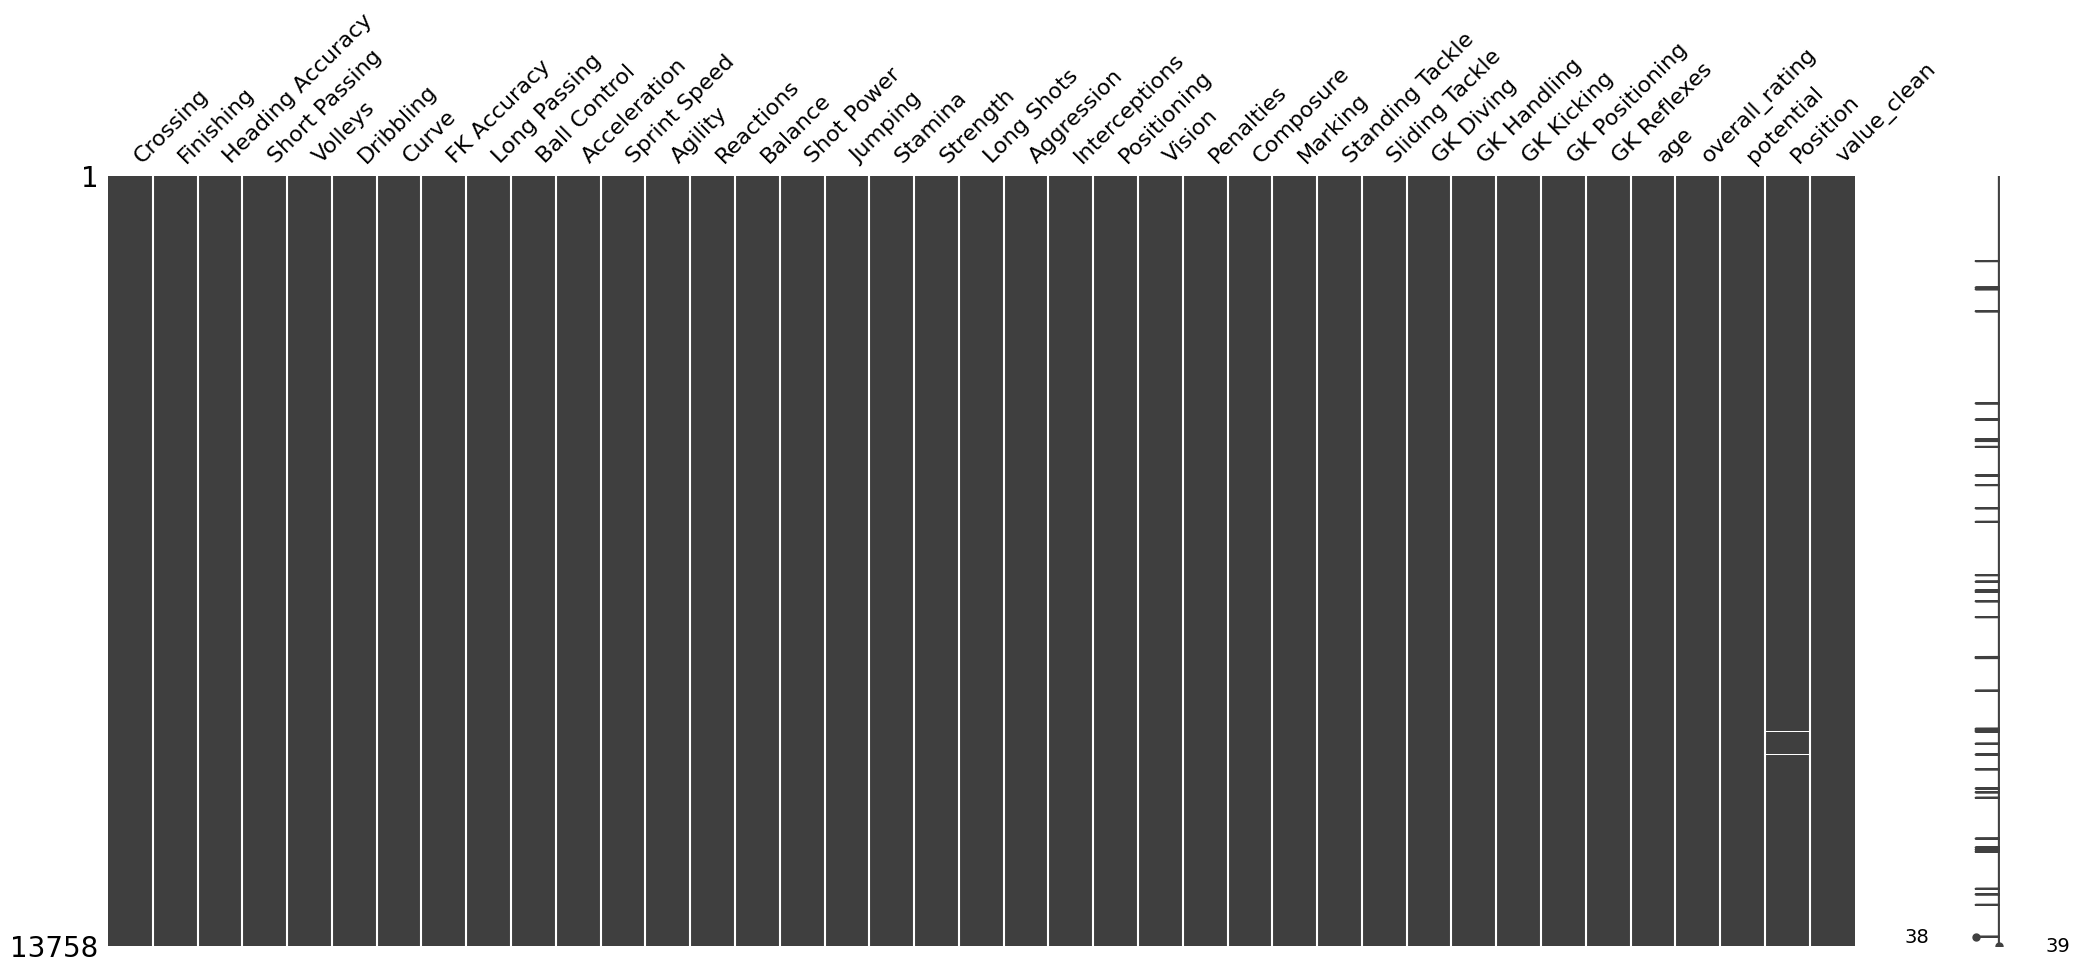

In [115]:
display(df.isnull().sum())

msno.matrix(df)
plt.show()

A característica 'position', que contém a posição do jogador, possui 39 pontos de dados faltantes. Como este é apenas um subconjunto muito pequeno dos dados totais (~13.800 pontos de dados no total), simplesmente vamos remover esses pontos de dados.

In [116]:
#Eliminar pontos de dados faltantes.
df = df.loc[df['Position'].notnull()].copy()

### Análise de Características

#### value_clean (variável alvo)

A coluna value_clean contém o valor de cada jogador em &euro;.

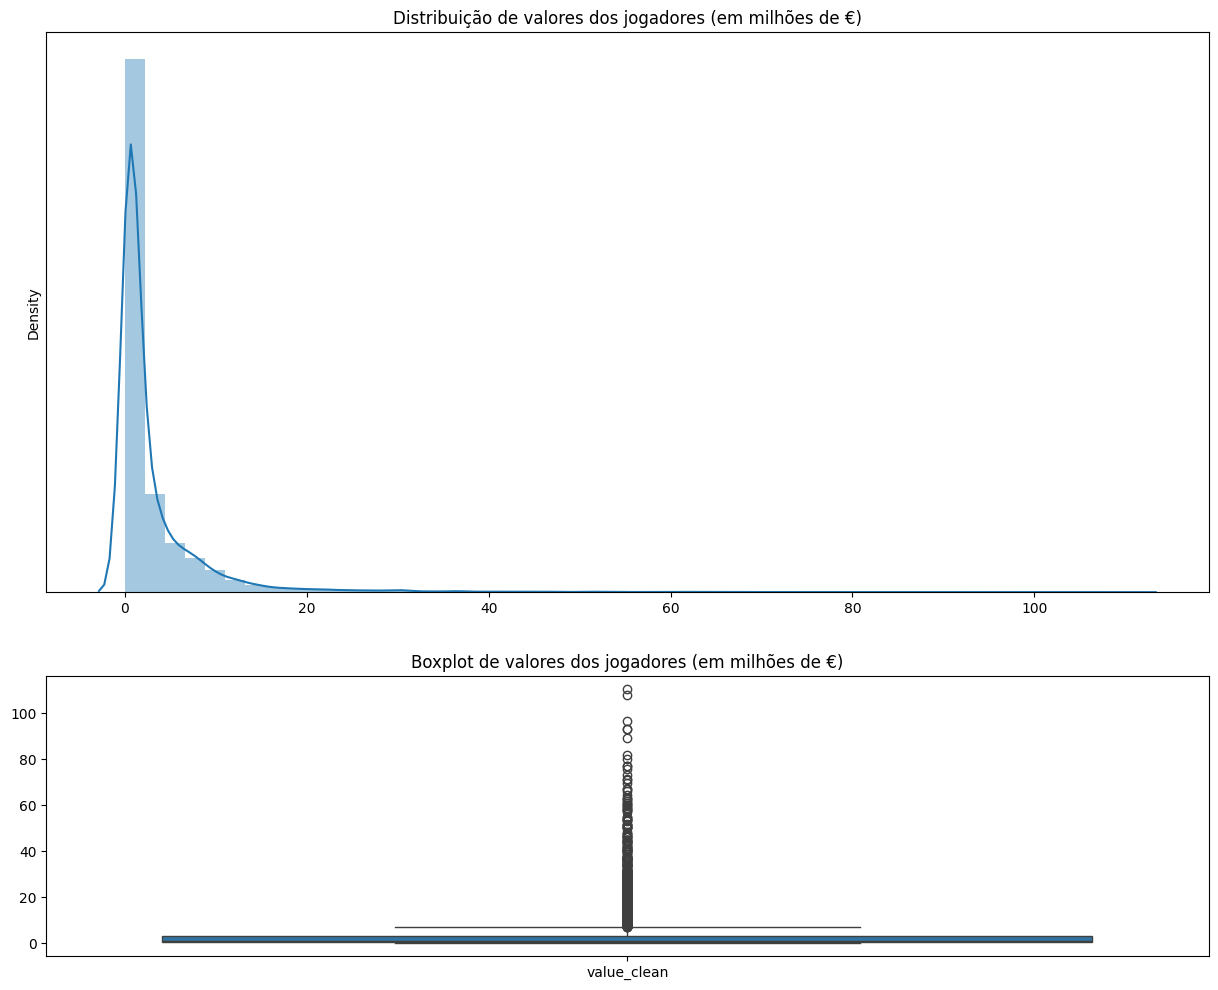

value_clean
count  13719.000000
mean       3.163104
std        6.367481
min        0.010000
25%        0.475000
50%        0.950000
75%        3.200000
max      110.500000

In [117]:
def plotar_distribuicao_e_estatisticas(caracteristica, nome):
    """Função auxiliar para plotar gráficos de distribuição"""
    
    fig, ax = plt.subplots(nrows=2, figsize=(15, 12), gridspec_kw={'height_ratios': [2, 1]})
    sns.distplot(caracteristica, ax=ax[0])
    ax[0].set_title(f"Distribuição de {nome}")
    ax[0].set_yticks([])
    
    sns.boxplot(caracteristica, ax=ax[1])
    ax[1].set_title(f"Boxplot de {nome}")
    plt.show()
    
    display(caracteristica.describe())

plotar_distribuicao_e_estatisticas(df[['value_clean']]/1_000_000, 'valores dos jogadores (em milhões de \N{euro sign})')

O valor do jogador é nossa característica alvo. Os valores de diferentes jogadores variam significativamente, especialmente para os jogadores de topo cujo valor aumenta exponencialmente. A distribuição mostra que a variável está muito positivamente distorcida, o que poderia dificultar a previsão de jogadores de valor muito alto durante a modelagem.

O jogador de maior valor tem &euro;110M e o jogador de menor valor tem apenas &euro;10.000. A média é aproximadamente &euro;3M, mas com um desvio padrão muito grande de &euro;6M.

Devido a essas estatísticas de distribuição desfavoráveis, será uma boa ideia aplicar uma transformação logarítmica nos dados para reduzir a variância na variável alvo.

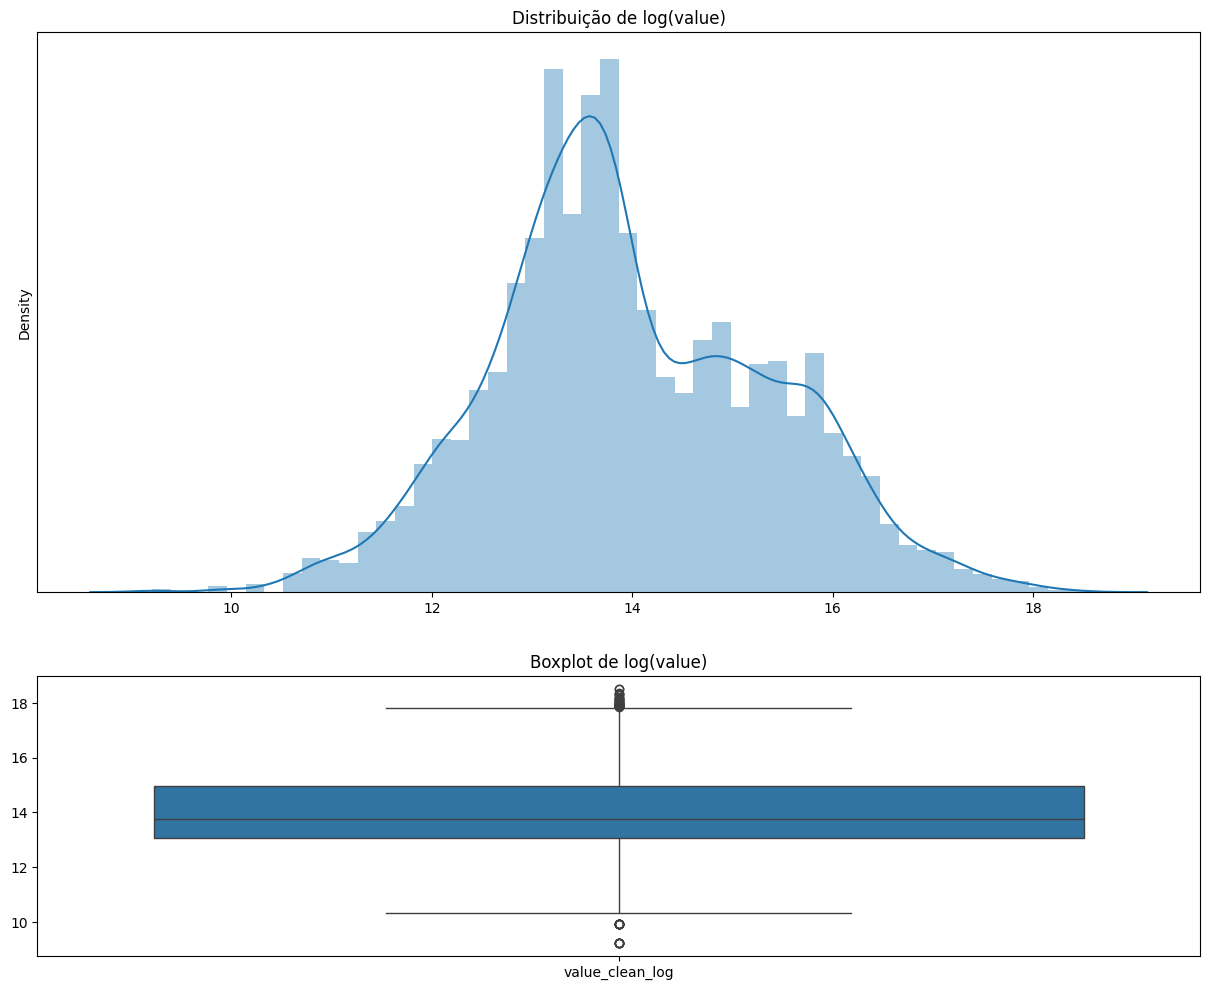

value_clean_log
count     13719.000000
mean         13.974646
std           1.387843
min           9.210340
25%          13.071070
50%          13.764217
75%          14.978661
max          18.520526

In [118]:
#criar transformação em log
df['value_clean_log'] = np.log(df['value_clean'])

plotar_distribuicao_e_estatisticas(df[['value_clean_log']],'log(value)')

A variável alvo agora parece mais distribuída normalmente e tem um desvio padrão muito menor em comparação com a média.

O gráfico de caixa mostra que a maioria dos dados está dentro da faixa interquartil, com alguns valores discrepantes nos extremos superior e inferior.

#### Idade

A idade de cada jogador

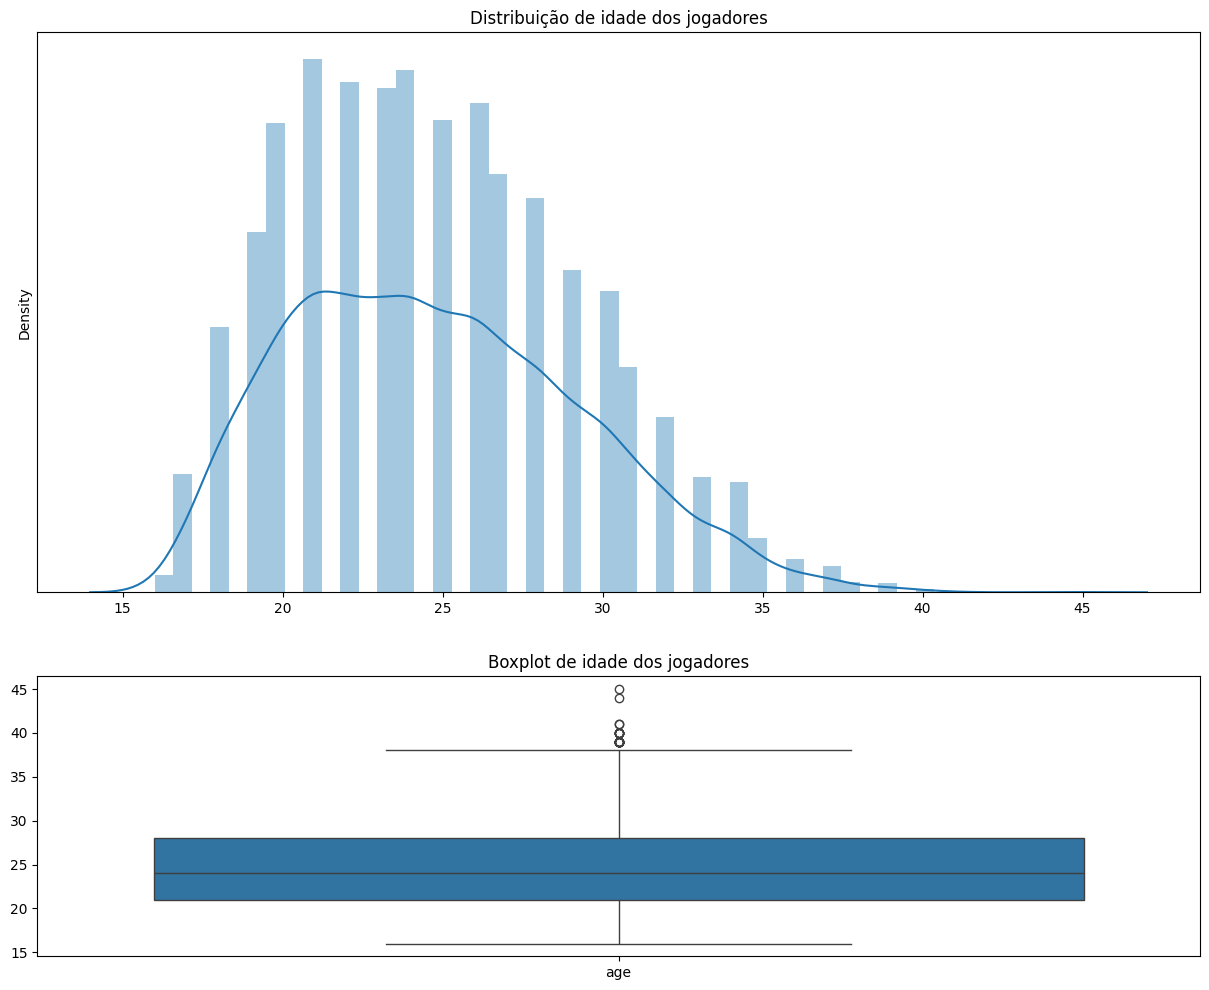

age
count  13719.000000
mean      24.803120
std        4.516523
min       16.000000
25%       21.000000
50%       24.000000
75%       28.000000
max       45.000000

In [119]:
plotar_distribuicao_e_estatisticas(df[['age']],'idade dos jogadores')

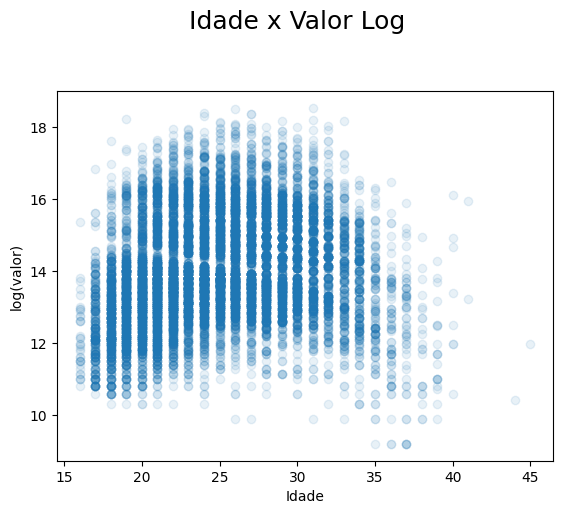

Correlação de Pearson = 0.18421933332162066


In [120]:
plt.scatter(x=df['age'],y=df['value_clean_log'],alpha=0.1)
plt.suptitle("Idade x Valor Log",fontsize=18,y=1.05)
plt.xlabel("Idade")
plt.ylabel("log(valor)")
plt.show()


print(f"Correlação de Pearson = {pearsonr(df['value_clean_log'],df['age'])[0]}")

Parece haver uma leve correlação positiva entre idade e valor (0.18), o que sugere que a experiência aumenta as avaliações, no entanto, isso é válido apenas até certo ponto. Quando a idade do jogador é aproximadamente >35 anos, os valores tendem a diminuir. Isso faz sentido, já que jogadores mais velhos têm menos anos de carreira pela frente e, portanto, têm menos valor a longo prazo para o clube.

**Posição do Jogador**

A posição favorita de cada jogador (por exemplo, ST, RM, CF, GK etc.).

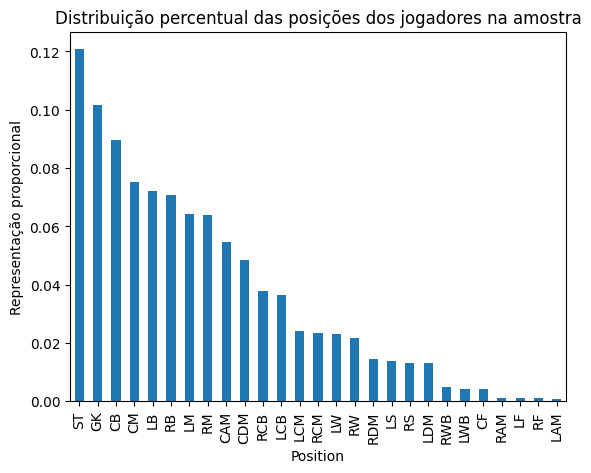

Número de posições únicas = 27


In [121]:
df['Position'].value_counts(normalize=True).plot(kind='bar')
plt.title("Distribuição percentual das posições dos jogadores na amostra")
plt.ylabel("Representação proporcional")
plt.show()

print(f"Número de posições únicas = {df['Position'].nunique()}")

A posição é a única característica categórica nos dados.

Curiosamente, o atacante é a posição mais prevalente no conjunto de dados, seguido pelos goleiros.

Existem 27 posições únicas no conjunto de dados. Isso é bastante para uma variável categórica e pode ser sensato agrupar essas posições em categorias mais gerais (por exemplo, atacante, meio-campo, defensor etc.). 

Vamos criar uma nova característica para esses agrupamentos.

In [122]:
def agrupar_posicoes(pos):
    """Converte a posição específica em uma categoria mais geral"""
    
    DICIONARIO_POSICOES = {
        'attack': ['CF', 'RF', 'LF', 'ST', 'LS', 'RS'],
        'midfield': ['CM', 'CAM', 'RM', 'CDM', 'LM', 'RCM', 'LCM', 'RDM', 'LDM', 'RAM', 'LAM', 'LW', 'RW'],
        'defence': ['LCB', 'CB', 'RB', 'RCB', 'LWB', 'LB', 'RWB'],
        'goalkeeper': ['GK']}

    for categoria, lista_pos in DICIONARIO_POSICOES.items():
        if pos in lista_pos:
            return categoria
    
    return np.nan

In [123]:
df['Categoria'] = df['Position'].apply(agrupar_posicoes)

del df['Position']

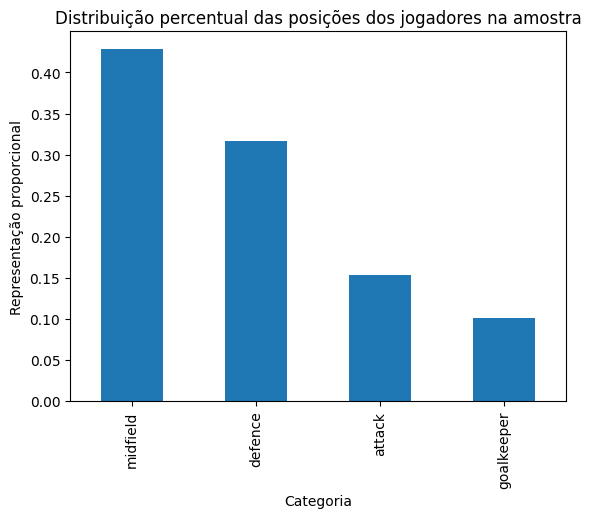

In [124]:
df['Categoria'].value_counts(normalize=True).plot(kind='bar')
plt.title("Distribuição percentual das posições dos jogadores na amostra")
plt.ylabel("Representação proporcional")
plt.show()


Essa nova característica foi reduzida para apenas quatro categorias diferentes.

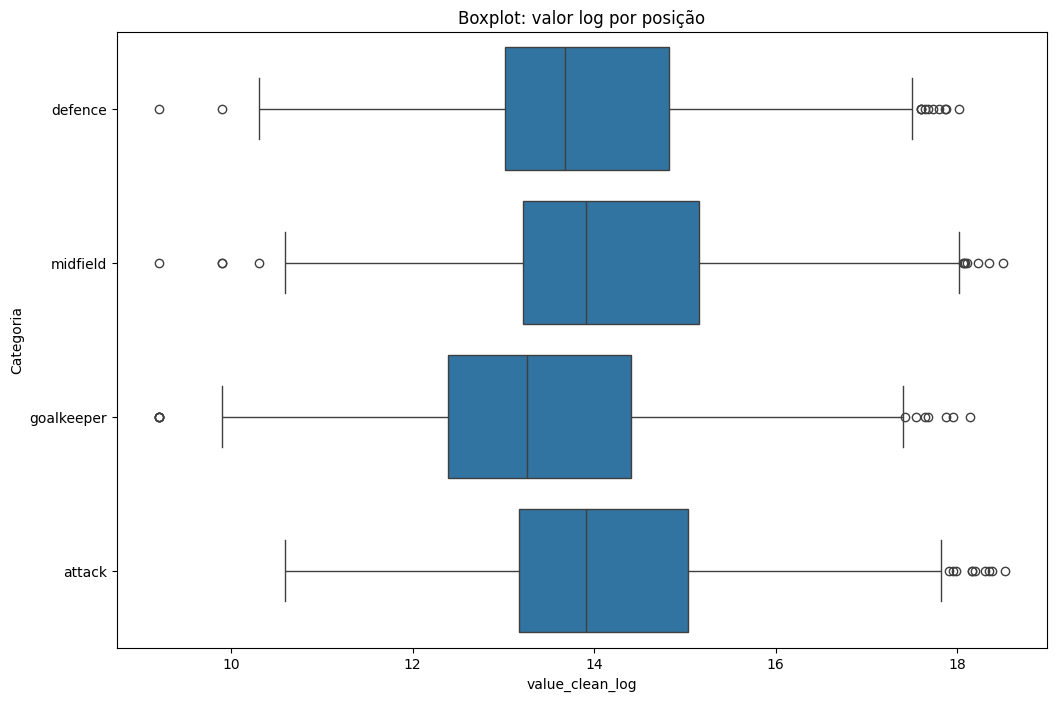

In [125]:
plt.figure(figsize=(12,8))
sns.boxplot(x='value_clean_log',y='Categoria',data=df)
plt.title("Boxplot: valor log por posição")
plt.show()

Ao analisar a distribuição das avaliações, percebemos que as distribuições de log de valor são semelhantes para cada categoria de posição. Os goleiros tendem a ter valores médios mais baixos, enquanto os atacantes tendem a ter um 'valor' mais alto, como seria de se esperar. Os atacantes têm mais outliers no extremo superior de sua distribuição. Observe também que esta é uma escala logarítmica, então, embora as distribuições sejam semelhantes, em termos reais, os atacantes têm um valor significativamente maior.

**Atributos do jogador**

Existem 34 colunas diferentes que descrevem os atributos de jogo do jogador.

In [126]:
ATRIBUTOS

['Crossing',
 'Finishing',
 'Heading Accuracy',
 'Short Passing',
 'Volleys',
 'Dribbling',
 'Curve',
 'FK Accuracy',
 'Long Passing',
 'Ball Control',
 'Acceleration',
 'Sprint Speed',
 'Agility',
 'Reactions',
 'Balance',
 'Shot Power',
 'Jumping',
 'Stamina',
 'Strength',
 'Long Shots',
 'Aggression',
 'Interceptions',
 'Positioning',
 'Vision',
 'Penalties',
 'Composure',
 'Marking',
 'Standing Tackle',
 'Sliding Tackle',
 'GK Diving',
 'GK Handling',
 'GK Kicking',
 'GK Positioning',
 'GK Reflexes']

I would assume that a lot of these features will be highly correlated with each other (e.g. Acceleration and sprint speed or goal keeping attributes will be negatively correlated with attacking attributes such as shooting, dribbling etc.), there could be scope to reduce the number of these features if necessary to improve the model and reduce complexity.

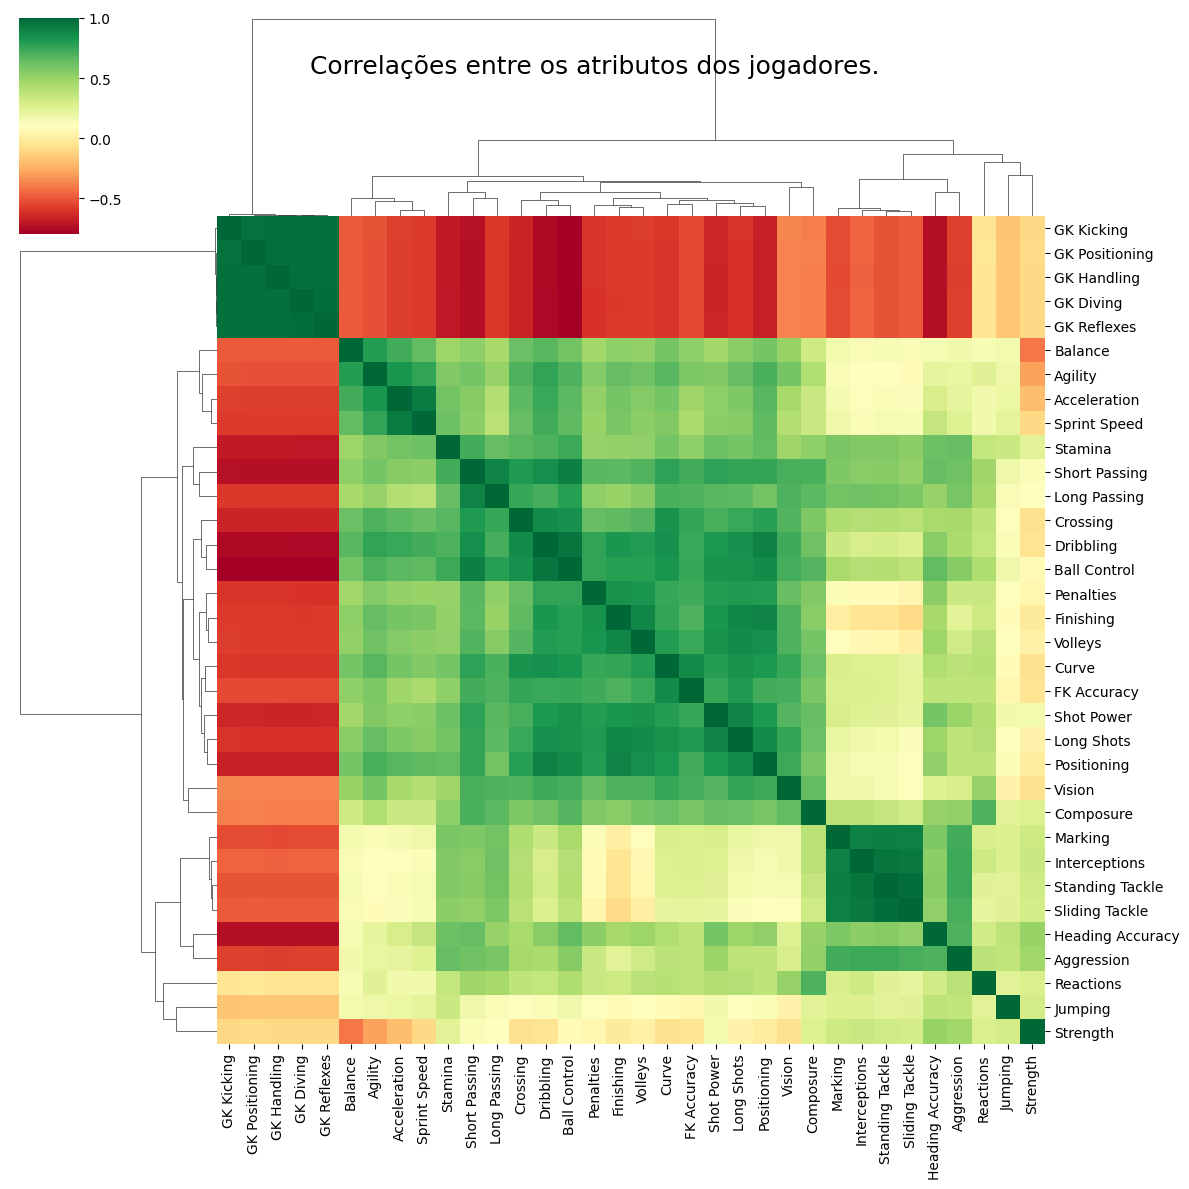

In [127]:
sns.clustermap(df[ATRIBUTOS].corr(),cmap='RdYlGn',figsize=(12,12))
plt.suptitle("Correlações entre os atributos dos jogadores.",fontsize=18,y=0.95)
plt.show()

Existem várias características altamente correlacionadas. Notavelmente, os atributos de goleiro (chute de goleiro, posicionamento de goleiro, manuseio de goleiro, mergulho de goleiro e reflexos de goleiro) são muito correlacionados entre si e negativamente correlacionados com os atributos de campo. Os atributos de campo geralmente estão todos correlacionados entre si. Os atributos de defesa (marcação, interceptações, carrinho, etc.) estão muito correlacionados entre si, no entanto, os atributos de ataque não são tão fortemente correlacionados. Isso mostra que, geralmente, goleiros e defensores têm um conjunto de habilidades "padrão", enquanto os jogadores de ataque têm conjuntos de habilidades mais específicos (por exemplo, particularmente bons em voleios ou cruzamentos, mas não necessariamente ambos).

**Potencial do Jogador**

Esse é o rating geral que o SOFIFA prevê ser o potencial futuro do jogador.

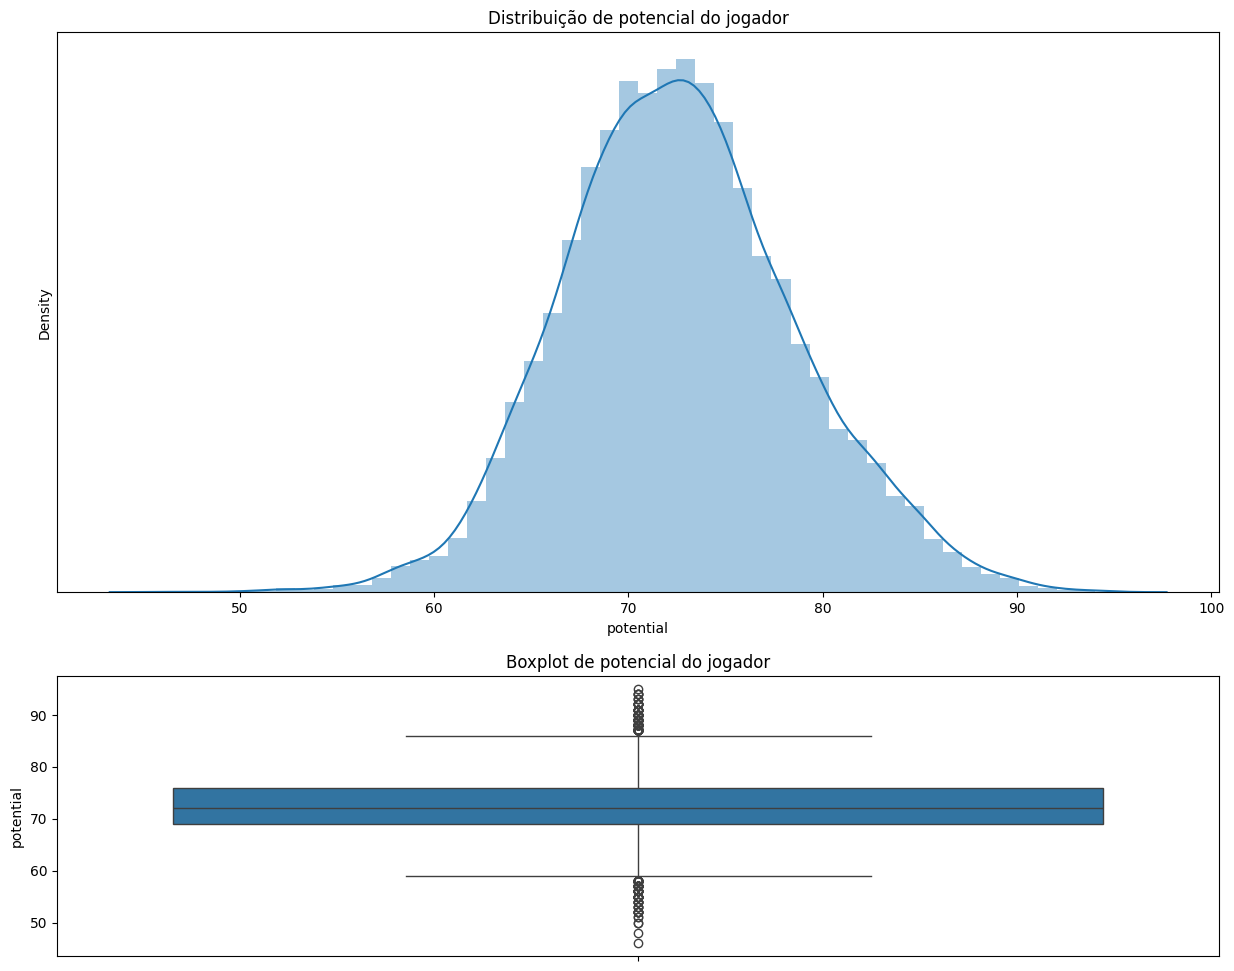

count    13719.000000
mean        72.657482
std          6.027961
min         46.000000
25%         69.000000
50%         72.000000
75%         76.000000
max         95.000000
Name: potential, dtype: float64

In [128]:
plotar_distribuicao_e_estatisticas(df['potential'],'potencial do jogador')

O potencial do jogador é distribuído de forma bastante normal, com uma média de 72.

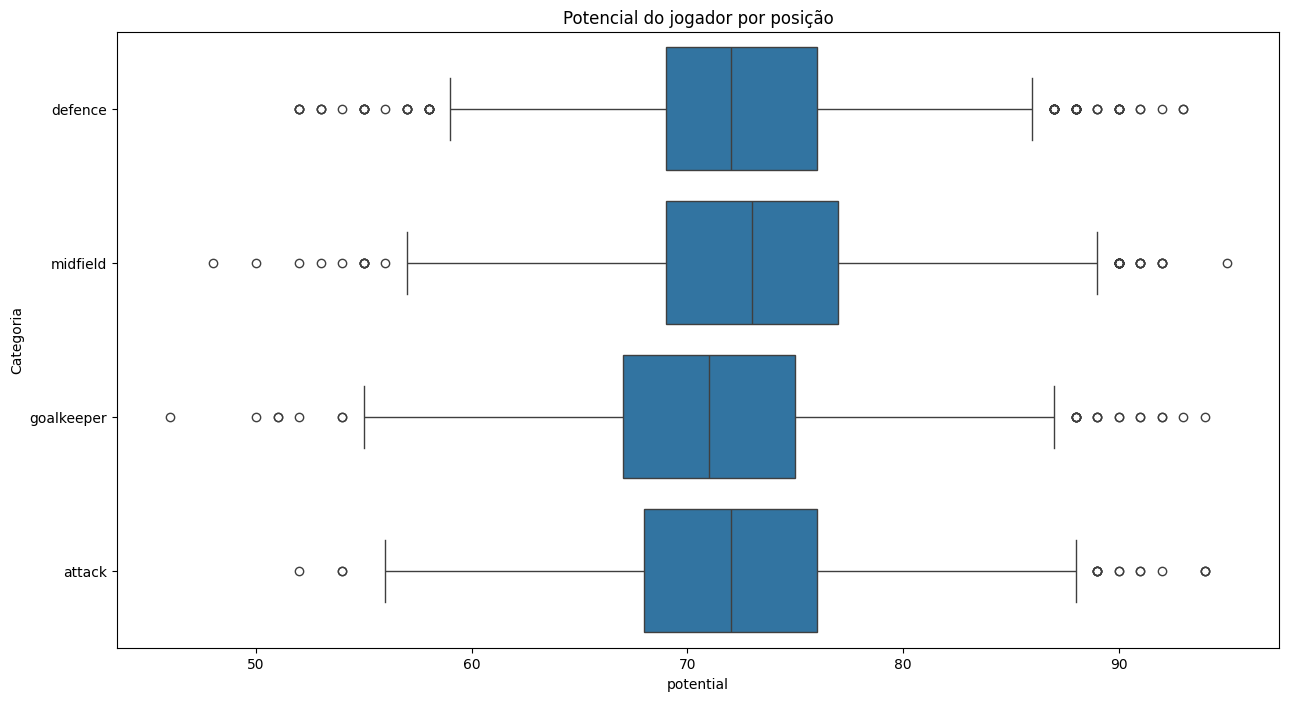

In [129]:
plt.figure(figsize=(15,8))
sns.boxplot(x='potential',y='Categoria',data=df)
plt.title("Potencial do jogador por posição")
plt.show()

O potencial do jogador não parece ser aparentemente diferente para as diferentes posições

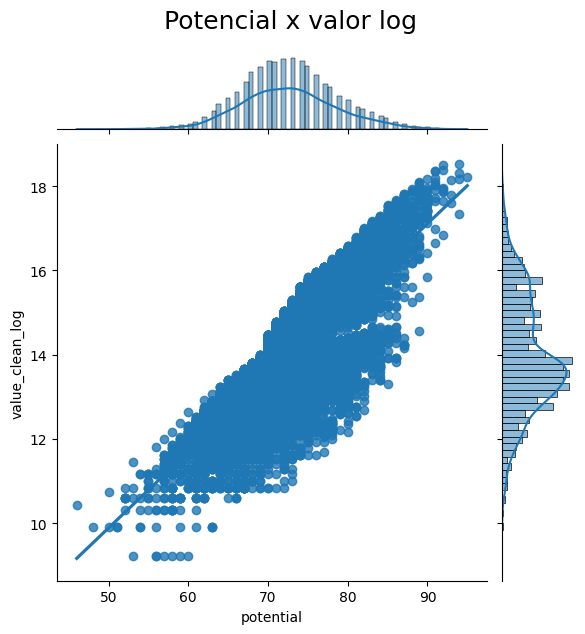

In [130]:
sns.jointplot(x='potential',y='value_clean_log',data=df,kind='reg')
plt.suptitle("Potencial x valor log",fontsize=18,y=1.05)
plt.show()

Há uma forte correlação positiva entre o potencial e a variável alvo, log(valor).

O potencial do jogador e a classificação geral provavelmente estão muito correlacionados, para verificar isso, podemos plotar o potencial versus a classificação geral.

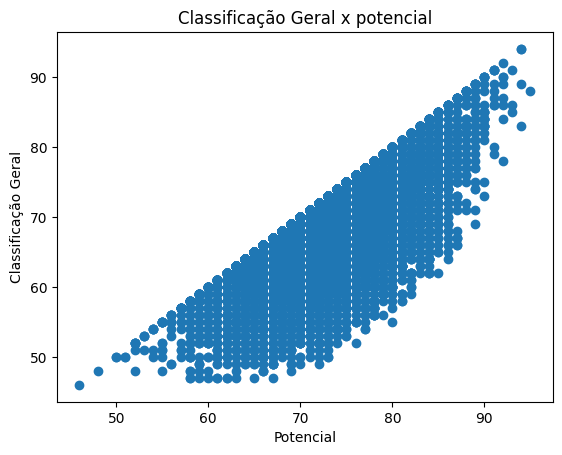

Correlação de Pearson = 0.6660520899052282


In [131]:
plt.scatter(x=df['potential'],y=df['overall_rating'])
plt.xlabel("Potencial")
plt.ylabel("Classificação Geral")
plt.title("Classificação Geral x potencial")
plt.show()

print(f"Correlação de Pearson = {pearsonr(df['potential'],df['overall_rating'])[0]}")

Podemos ver que a classificação geral é sempre menor do que o potencial do jogador, o que faz sentido. No entanto, a correlação é de apenas 0,66, portanto, provavelmente é útil manter ambas as características para modelagem.

Outra característica que pode ser de interesse é a diferença entre a classificação atual do jogador e o potencial do jogador. Vamos criar essa característica e chamá-la de 'potencial_crescimento'. Jogadores com maior potencial de crescimento podem ter um valor mais alto para sua classificação geral atual.

In [132]:
#Criano nova característica
df['potencial_crescimento'] = df['potential']-df['overall_rating']

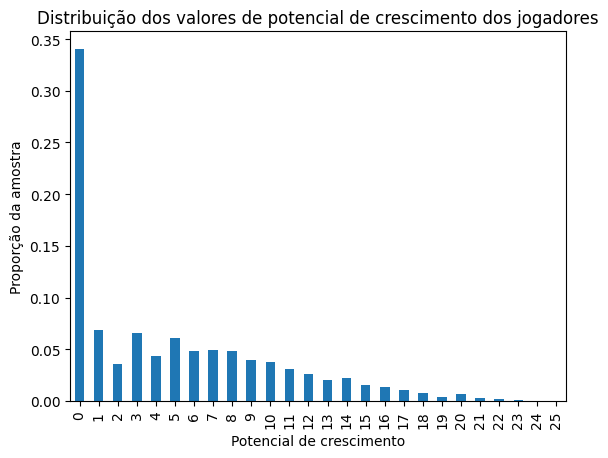

In [133]:
df['potencial_crescimento'].value_counts(normalize=True).sort_index().plot(kind='bar')
plt.title("Distribuição dos valores de potencial de crescimento dos jogadores")
plt.ylabel("Proporção da amostra")
plt.xlabel("Potencial de crescimento")
plt.show()

Podemos ver que a maioria dos jogadores já está em seu potencial máximo (diferença entre o potencial e a classificação geral atual = 0). O crescimento potencial varia até 25 pontos adicionais.

Para ver como esse novo recurso se correlaciona com a variável de destino, podemos plotar o potencial de crescimento x log(valor) e também calcular a correlação de Pearson. O potencial de crescimento também provavelmente está correlacionado com a classificação geral, então também vamos plotar essa relação.

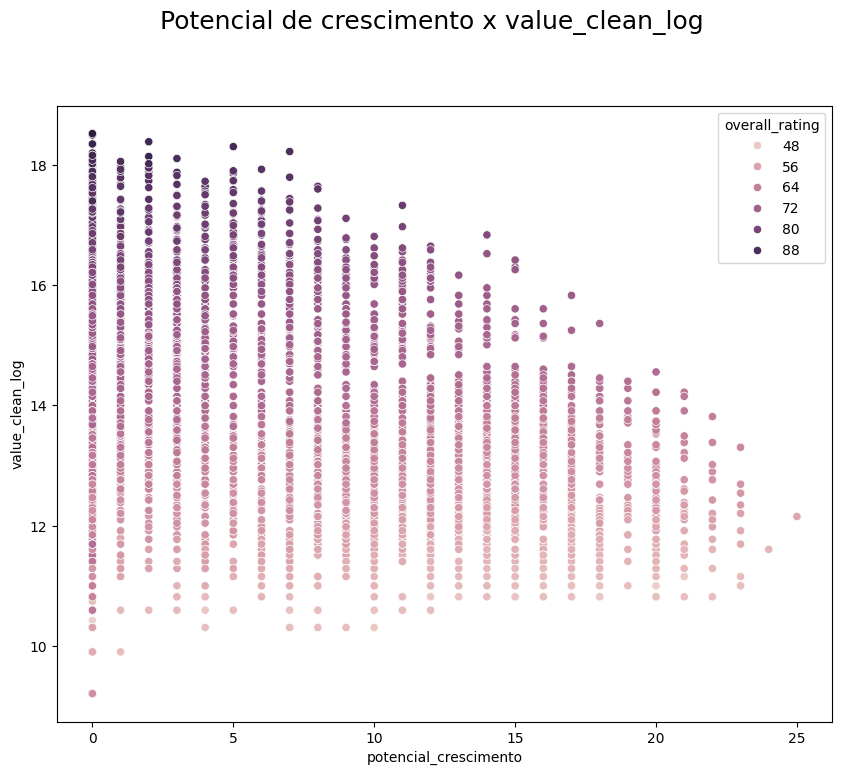

Correlação de Pearson = -0.31245629202124453


In [134]:
plt.figure(figsize=(10,8))
sns.scatterplot(x='potencial_crescimento',y='value_clean_log',data=df,hue='overall_rating')
plt.suptitle("Potencial de crescimento x value_clean_log",fontsize=18,y=1)
plt.show()

print(f"Correlação de Pearson = {pearsonr(df['value_clean_log'],df['potencial_crescimento'])[0]}")


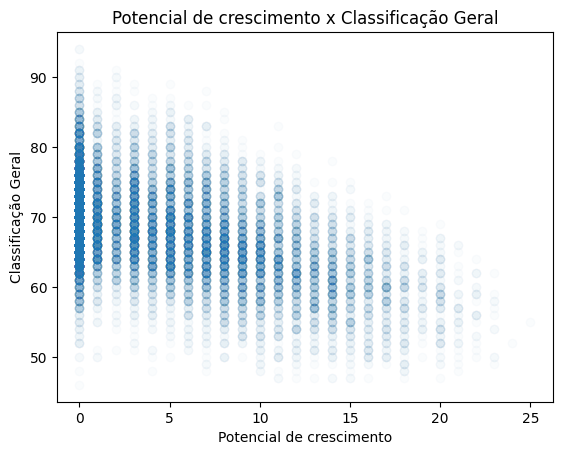

Correlação de Pearson = -0.5160447194481907


In [135]:
plt.scatter(x=df['potencial_crescimento'],y=df['overall_rating'],alpha=0.02)
plt.title("Potencial de crescimento x Classificação Geral")
plt.xlabel("Potencial de crescimento")
plt.ylabel("Classificação Geral")
plt.show()
print(f"Correlação de Pearson = {pearsonr(x=df['potencial_crescimento'],y=df['overall_rating'])[0]}")

Curiosamente, o crescimento potencial está negativamente correlacionado com o log do valor, o que nos diz que quanto maior o crescimento potencial, menor é o valor atual do jogador. Isso é intuitivo, pois jogadores com alto potencial de crescimento quase por definição devem ter uma classificação geral mais baixa e, portanto, um valor atual mais baixo. No entanto, o gráfico do crescimento potencial contra o log do valor mostra uma redução do 'funil' e uma menor variância nos valores dos jogadores com alto potencial de crescimento, sugerindo que os jogadores com alto potencial de crescimento são valorizados a um preço premium.

Ao observar o gráfico de classificação geral x potencial de crescimento, a correlação é apenas -0,51, sugerindo que o novo recurso contém informações novas e pode ser útil para adicionar ao modelo.

In [136]:
#del df['potencial_crescimento']

**Classificação geral do jogador**

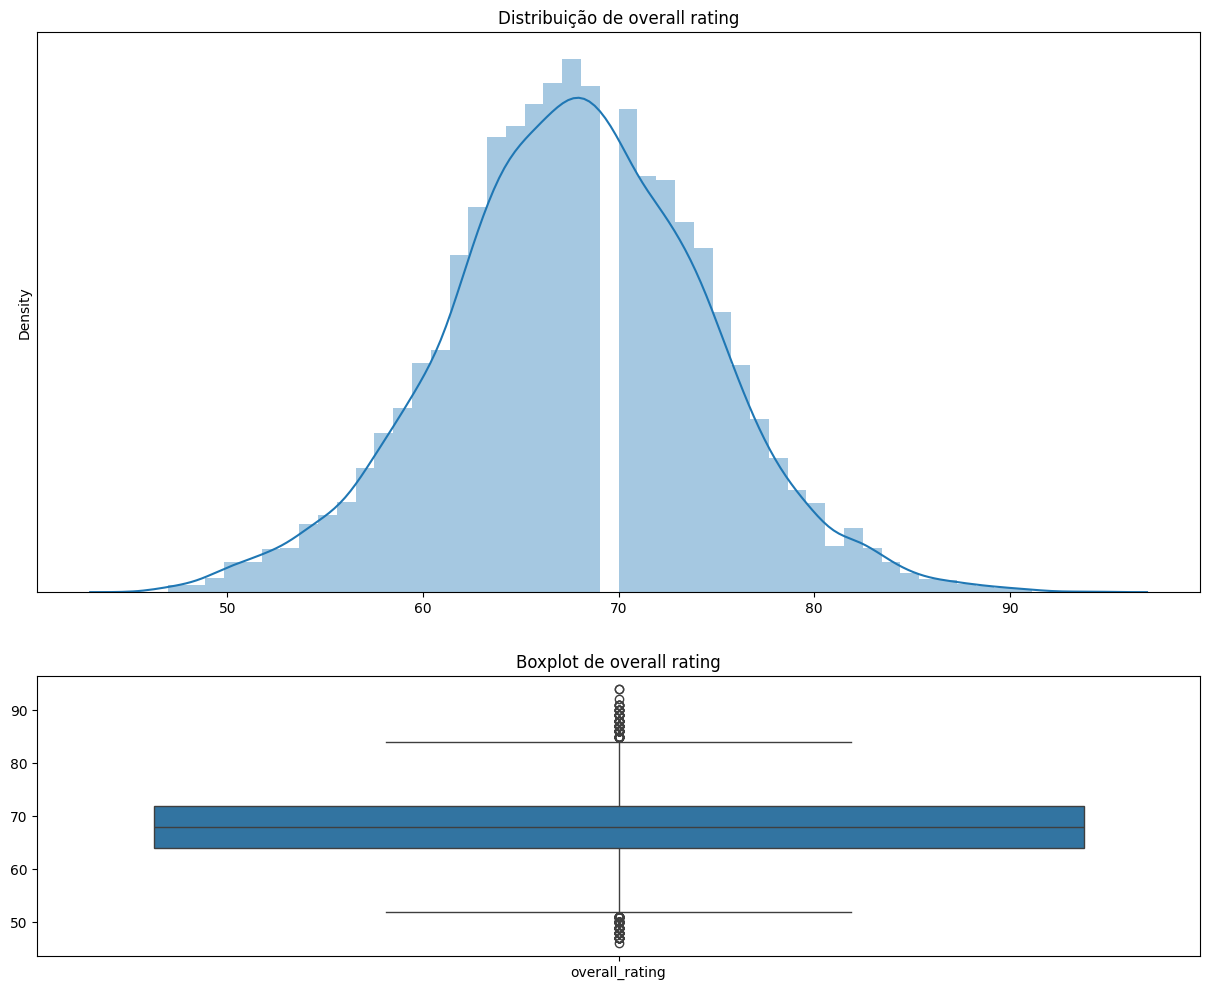

overall_rating
count    13719.000000
mean        67.789416
std          6.723772
min         46.000000
25%         64.000000
50%         68.000000
75%         72.000000
max         94.000000

In [137]:
plotar_distribuicao_e_estatisticas(df[['overall_rating']],'overall rating')

A classificação geral do jogador é normalmente distribuída, com uma média de 68, um mínimo de 46 e um máximo de 94. A distribuição apresenta longas caudas em ambos os lados, com outliers baixos e altos.

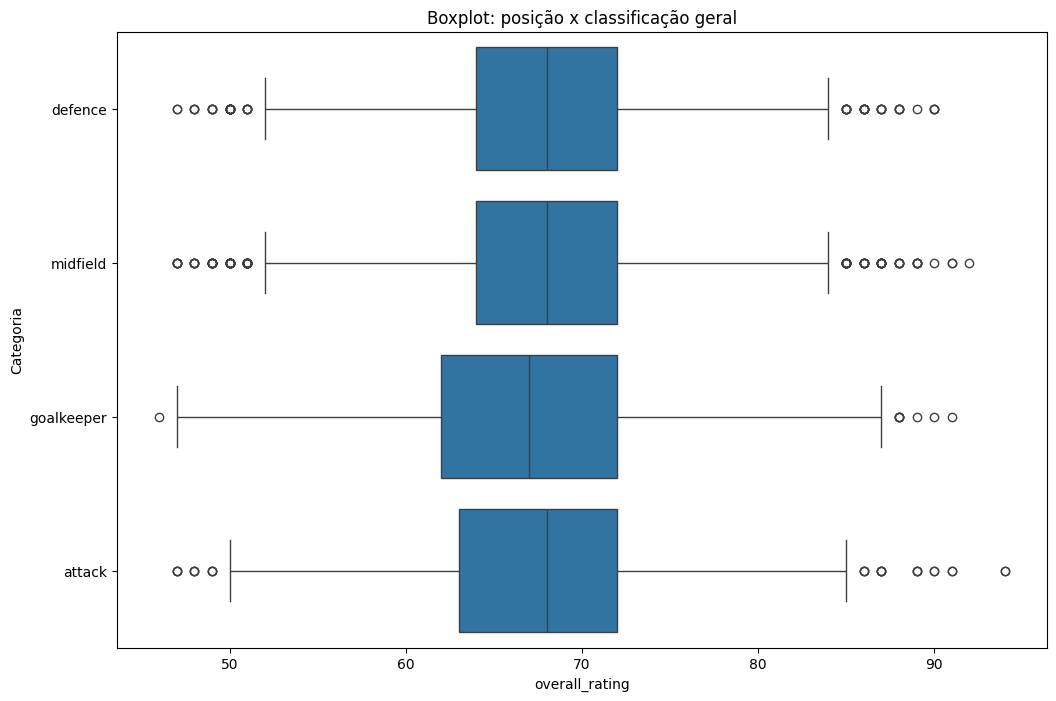

In [138]:
plt.figure(figsize=(12,8))
sns.boxplot(x='overall_rating',y='Categoria',data=df)
plt.title("Boxplot: posição x classificação geral")
plt.show()

As classificações gerais para cada posição de jogador são muito semelhantes. Curiosamente, isso contrasta com o boxplot da posição do jogador x log do valor, onde os atacantes tinham um valor mais alto. Isso sugere que os atacantes têm um valor premium em comparação com sua classificação geral.

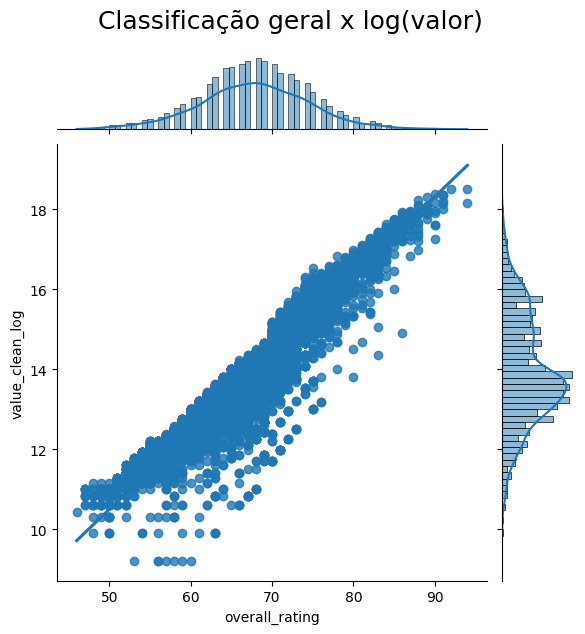

Correlação de Pearson = 0.9471756497749729
R2 = 0.8971417115266421


In [139]:
sns.jointplot(x=df['overall_rating'],
              y=df['value_clean_log'],
              kind="reg")
plt.suptitle("Classificação geral x log(valor)", fontsize=18, y=1.05)
plt.show()
print(f"Correlação de Pearson = {pearsonr(df['overall_rating'],df['value_clean_log'])[0]}")
print(f"R2 = {pearsonr(df['overall_rating'],df['value_clean_log'])[0]**2}")


A classificação geral está altamente correlacionada com o log do valor, com um R² de 0.89, e é provavelmente o recurso mais preditivo.

### Sumário - Análise Exploratória de Dados

1. A variável alvo, valor do jogador, foi transformada para logaritmo para normalizar a distribuição.

2. A posição do jogador, um atributo categórico com alta cardinalidade, foi convertida em posições mais gerais (por exemplo, atacante, defensor, meio-campista, goleiro etc.). A distribuição dos valores dos jogadores para cada posição foi semelhante, no entanto, os jogadores atacantes parecem ser valorizados premium para sua classificação geral.

3. Um novo recurso, crescimento potencial, foi criado calculando a diferença entre 'potencial' e 'classificação geral'. Este novo recurso mostrou que os jogadores com alto potencial de crescimento tendem a ser valorizados premium em relação a outros jogadores com a mesma classificação geral.

4. Os atributos de jogo (cruzamentos, passes etc.) tendem a ser fortemente correlacionados entre si, mas não correlacionam fortemente com o valor do jogador. Pode ser necessário combinar alguns desses atributos para reduzir a complexidade do modelo. Dos atributos de jogo, reações e compostura parecem ser os mais correlacionados com o valor.

5. O valor do jogador aumenta com a idade, no entanto, após cerca de 35 anos, o valor dos jogadores começa a cair.
Um resumo das correlações numéricas das características com a variável alvo (log(valor)) está resumido abaixo:

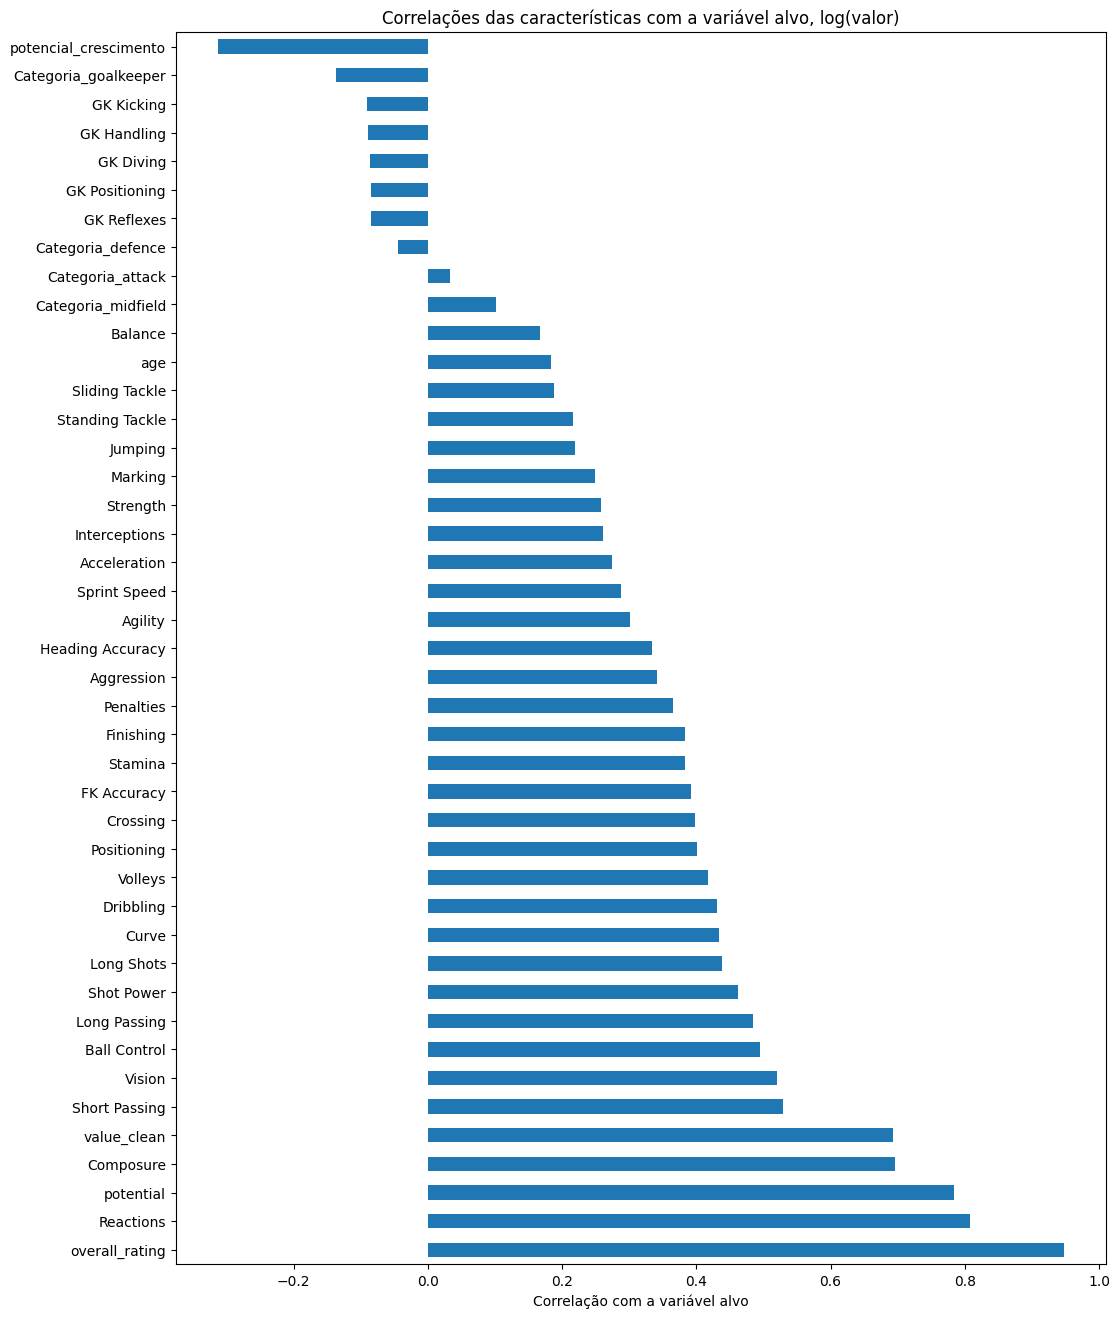

In [140]:
# Convertendo características categóricas em numéricas usando one-hot encoding
df_encoded = pd.get_dummies(df)

# Calculando a correlação entre as características e a variável alvo
correlation = df_encoded.corr()['value_clean_log'].sort_values(ascending=False)

# Plotando o gráfico de barras da correlação
correlation.iloc[1:].plot(kind='barh', figsize=(12, 16))
plt.xlabel("Correlação com a variável alvo")
plt.title("Correlações das características com a variável alvo, log(valor)")
plt.show()


------------------------

<a id='Modelagem'></a>
# 2. Modelagem

<a id='data_prep'></a>
## 2.1 Preparação dos Dados

Para a modelagem, criaremos uma nova função que carrega os dados brutos e aplica as etapas de limpeza de dados e criação de características realizadas na Análise Exploratória de Dados (EDA). Em seguida, criaremos a divisão de treino e teste e uma pipeline do sklearn para escalonamento e processamento de características.

In [141]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Carregar os dados brutos novamente
def make_data_set():
    """Carrega os dados brutos e aplica etapas iniciais de criação/processamento de recursos"""

    # Carregar os dados brutos
    raw_df = pd.read_csv("dados/dadosprocessados/dados_limpos.csv")
    df = raw_df.loc[raw_df['value_clean'] != 0].copy()  # deletar linhas com 0 na coluna value_clean

    # Selecionar recursos sensíveis
    df = df[ATRIBUTOS + ['age', 'overall_rating', 'potential', 'Position', 'value_clean']].copy()

    # Excluir dados ausentes na posição
    df = df.loc[df['Position'].notnull()].copy()

    # Criar categorias de posição do jogador
    df['Categoria'] = df['Position'].apply(agrupar_posicoes)
    del df['Position']

    # Criar novo recurso para crescimento potencial
    df['potential_growth'] = df['potential'] - df['overall_rating']

    # Transformar log no atributo value_clean
    df['target'] = np.log(df['value_clean'])
    del df['value_clean']

    # Garantir que não haja dados ausentes
    assert df.isnull().sum().sum() == 0

    # Embaralhar o dataframe para evitar qualquer viés na ordem que os dados foram coletados
    df_shuffled = shuffle(df, random_state=0)

    # Criar divisão de treino e teste
    return train_test_split(df_shuffled.iloc[:, :-1],
                            df_shuffled.iloc[:, -1],
                            test_size=0.33,
                            random_state=0)


In [142]:
# Criar conjuntos de treinamento e teste finais
X_train, X_test, y_train, y_test = make_data_set()

<a id ='baseline_model' ></a>
## 2.2 Modelo de referência

Para avaliar a eficácia do modelo de aprendizado de máquina, precisamos decidir qual métrica de precisão otimizar e também avaliar o desempenho do modelo em comparação com um modelo de referência simples.

Na seção de Análise Exploratória de Dados (EDA), descobrimos que a avaliação geral tinha a maior correlação com o valor do jogador (0.94). Portanto, o modelo mais simples com bom desempenho provavelmente será uma regressão linear da avaliação geral versus o logaritmo do valor.

Vamos otimizar para o RMSE (erro quadrático médio) porque queremos ser capazes de prever o valor de um jogador, especialmente os jogadores que estão significativamente subvalorizados ou supervalorizados. Portanto, queremos escolher uma métrica que penalize previsões muito ruins mais do que previsões que estão apenas ligeiramente fora do valor real. O RMSE é dado pela seguinte equação:

$$RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{e^2}}$$

Aqui, $e$ representa o erro (a diferença entre o previsto e o real).

Como este é um termo ao quadrado, erros grandes serão amplificados e aumentarão o RMSE, levando a um pior desempenho do modelo.

In [143]:
# Dicionário para armazenar os resultados da modelagem
resultados_modelagem = {}

# Calcular o R-quadrado ajustado
def calc_r2_ajustado(dados_treinamento, r2):
    """Calcula o R-quadrado ajustado para o modelo"""
    num_pontos_dados = len(dados_treinamento)
    
    if isinstance(dados_treinamento, pd.DataFrame):
        num_variaveis = len(dados_treinamento.columns)
    else:  # caso seja um array NumPy
        num_variaveis = dados_treinamento.shape[1]
    
    return 1 - ((1 - r2) * (num_pontos_dados - 1) / (num_pontos_dados - num_variaveis - 1))

In [144]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

x = X_train['overall_rating'].values.reshape(-1,1)
y = y_train.values.reshape(-1,1)

baseline_model = LinearRegression()
baseline_model.fit(x,y)

baseline_pred = baseline_model.predict(X_train['overall_rating'].values.reshape(-1,1))
baseline_RMSE = np.sqrt(mean_squared_error(y_train, baseline_pred))
baseline_r2 = r2_score(y_train,baseline_pred)
baseline_adj_r2 = calc_r2_ajustado(X_train[['overall_rating']],baseline_r2)

#add result to resultados_modelagem dictionary
resultados_modelagem['baseline model (linear regression)'] = {'rmse':baseline_RMSE,
                                                      'adj. r2':baseline_adj_r2}
pd.DataFrame.from_dict(resultados_modelagem,orient='index')

rmse   adj. r2
baseline model (linear regression)  0.438973  0.900383

A regressão linear base fornece um RMSE de 0,43 e um R-quadrado de 0,90. Este já é um modelo razoavelmente bom, no entanto, ainda há espaço para melhorias e também não fornece nenhum insight sobre outras variáveis que poderiam afetar o valor de cada jogador.

<a id ='mlr'></a>
## 2.3 Regressão Linear Múltipla


In [145]:
# Criar variáveis dummy para regressão linear múltipla
X_train_rlm = pd.get_dummies(X_train, drop_first=True)
X_test_rlm = pd.get_dummies(X_test, drop_first=True)

X_train_rlm.head()

Crossing  Finishing  Heading Accuracy  Short Passing  Volleys  \
104          54         55                34             68       48   
3367         83         72                42             73       73   
4816         60         62                54             62       71   
11395        39         62                44             47       50   
11263        51         54                47             63       45   

       Dribbling  Curve  FK Accuracy  Long Passing  Ball Control  \
104           68     58           50            60            71   
3367          76     83           84            72            74   
4816          72     65           45            59            68   
11395         66     50           51            37            68   
11263         63     50           51            53            64   

       Acceleration  Sprint Speed  Agility  Reactions  Balance  Shot Power  \
104              74            66       77         60       83          59   
3367             76            74       84         73       73          83   
4816             75            77       69         62       58          71   
11395            73            78       73         61       71          61   
11263            67            63       69         54       71          59   

       Jumping  Stamina  Strength  Long Shots  Aggression  Interceptions  \
104         51       64        43          61          53             44   
3367        62       71        61          81          53             35   
4816        60       65        70          63          51             33   
11395       33       48        59          63          46             38   
11263       55       60        62          49          40             26   

       Positioning  Vision  Penalties  Composure  Marking  Standing Tackle  \
104             59      62         48         62       37               45   
3367            71      83         85         77       42               21   
4816            68      62         56         63       32               31   
11395           67      46         62         44       41               20   
11263           53      58         48         56       28               39   

       Sliding Tackle  GK Diving  GK Handling  GK Kicking  GK Positioning  \
104                41         12           11           8              12   
3367               20         10            7          14               7   
4816               30         11            8          13               8   
11395              22          8            9          13               6   
11263              45         15            7          11              11   

       GK Reflexes  age  overall_rating  potential  potential_growth  \
104              6   18              66         82                16   
3367            10   31              76         76                 0   
4816             8   21              67         75                 8   
11395           13   24              59         65                 6   
11263           12   24              60         64                 4   

       Categoria_defence  Categoria_goalkeeper  Categoria_midfield  
104                False                 False                True  
3367               False                 False                True  
4816               False                 False                True  
11395              False                 False                True  
11263              False                 False                True

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 target   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          7.179e+05
Date:                Wed, 05 Jun 2024   Prob (F-statistic):                        0.00
Time:                        18:21:58   Log-Likelihood:                         -320.60
No. Observations:                9191   AIC:                                      721.2
Df Residuals:                    9151   BIC:                                      1006.
Df Model:                          40                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Crossing                -0.0014      0.000     -3.675      0.000      -0.002      -0.001
Finishing                0.0010      0.000      2.164      0.031    9.22e-05       0.002
Heading Accuracy         0.0024      0.000      6.129      0.000       0.002       0.003
Short Passing            0.0010      0.001      1.484      0.138      -0.000       0.002
Volleys                  0.0006      0.000      1.467      0.143      -0.000       0.001
Dribbling                0.0001      0.001      0.215      0.830      -0.001       0.001
Curve                    0.0002      0.000      0.584      0.559      -0.001       0.001
FK Accuracy              0.0009      0.000      2.787      0.005       0.000       0.002
Long Passing            -0.0003      0.000     -0.604      0.546      -0.001       0.001
Ball Control            -0.0024      0.001     -3.200      0.001      -0.004      -0.001
Acceleration             0.0013      0.001      2.375      0.018       0.000       0.002
Sprint Speed             0.0004      0.001      0.702      0.483      -0.001       0.001
Agility                 -0.0002      0.000     -0.569      0.569      -0.001       0.001
Reactions             9.072e-05      0.001      0.142      0.887      -0.001       0.001
Balance                  0.0015      0.000      4.352      0.000       0.001       0.002
Shot Power           -9.341e-05      0.000     -0.231      0.817      -0.001       0.001
Jumping              -7.115e-05      0.000     -0.256      0.798      -0.001       0.000
Stamina                  0.0015      0.000      4.428      0.000       0.001       0.002
Strength                 0.0015      0.000      4.359      0.000       0.001       0.002
Long Shots              -0.0007      0.000     -1.590      0.112      -0.002       0.000
Aggression              -0.0005      0.000     -1.595      0.111      -0.001       0.000
Interceptions           -0.0003      0.000     -0.696      0.486      -0.001       0.001
Positioning              0.0013      0.000      2.987      0.003       0.000       0.002
Vision                   0.0002      0.000      0.411      0.681      -0.001       0.001
Penalties                0.0005      0.000      1.440      0.150      -0.000       0.001
Composure               -0.0017      0.000     -3.804      0.000      -0.003      -0.001
Marking                 -0.0016      0.000     -4.389      0.000      -0.002      -0.001
Standing Tackle          0.0007      0.001      1.072      0.284      -0.001       0.002
Sliding Tackle          -0.0009      0.001     -1.469      0.142      -0.002       0.000
GK Diving                0.0008      0.001      0.975      0.330      -0.001       0.002
GK Handling             -0.0026      0.001     

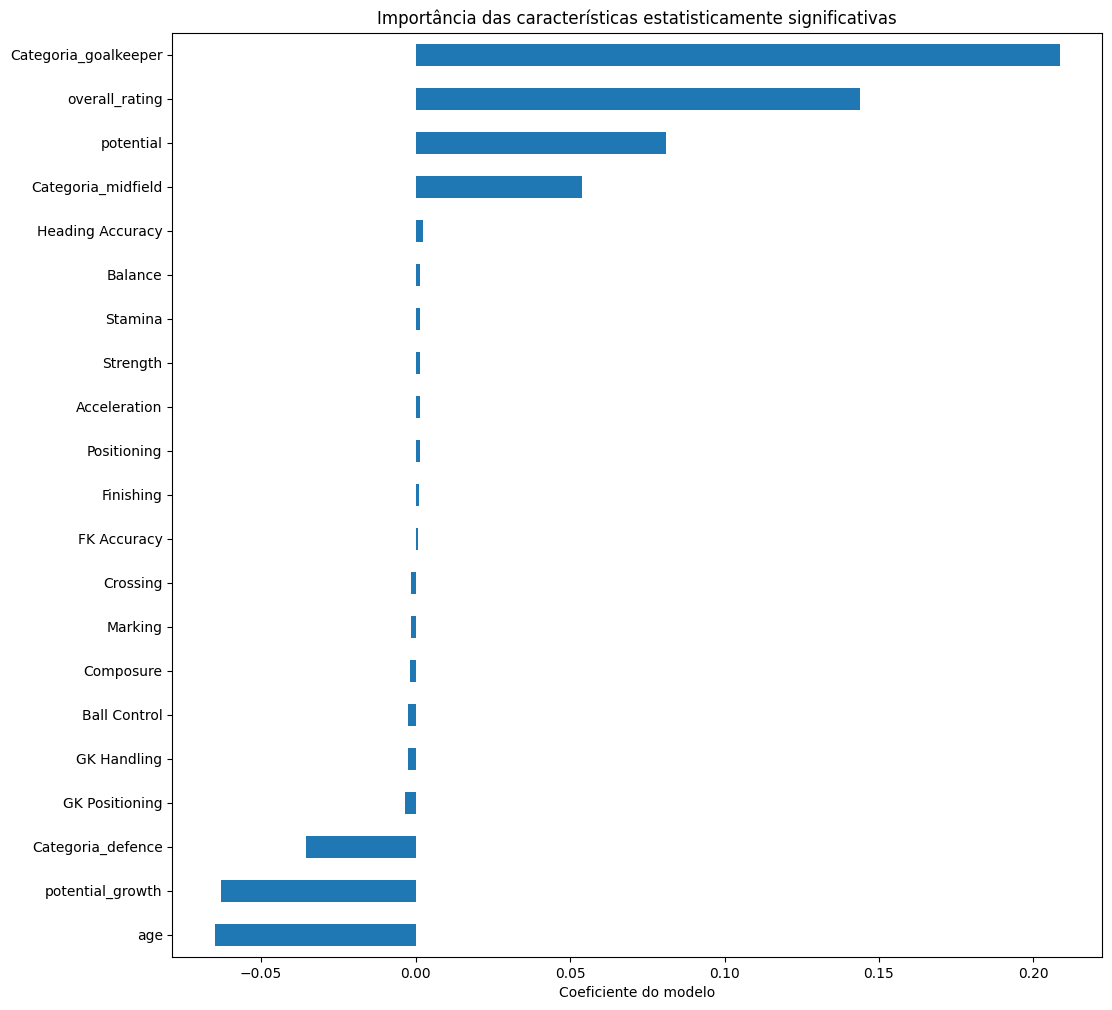

rmse   adj. r2  r2 ajustado
baseline model (linear regression)  0.438973  0.900383          NaN
Regressão Linear Múltipla           0.250560       NaN     0.967403

In [146]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import mean_squared_error, r2_score

# Garantir que os dados de treinamento estejam no tipo correto
X_train_rlm = X_train_rlm.astype(float)
y_train = y_train.astype(float)

# Criar e ajustar o modelo de regressão linear múltipla
mlr_model = sm.OLS(y_train, X_train_rlm).fit()
mlr_pred = mlr_model.predict(X_train_rlm)

# Calcular o RMSE e o R-quadrado
mlr_RMSE = np.sqrt(mean_squared_error(y_train, mlr_pred))
mlr_r2 = r2_score(y_train, mlr_pred)
mlr_adj_r2 = calc_r2_ajustado(X_train_rlm, mlr_r2)

# Exibir os resultados da regressão
display(HTML("<h3>Resultados da Regressão</h3>"))
display(mlr_model.summary())

# Exibir a importância das características estatisticamente significativas
display(HTML("<h3>Importâncias das Características Estatisticamente Significativas</h3>"))
plt.figure(figsize=(12, 12))
mlr_model.params[mlr_model.pvalues < 0.05].sort_values().plot(kind='barh')
plt.title("Importância das características estatisticamente significativas")
plt.xlabel("Coeficiente do modelo")
plt.show()

# Exibir as variáveis estatisticamente insignificantes
display(HTML(f"""<h4>Variáveis estatisticamente insignificantes</h4><p>{mlr_model.params[mlr_model.pvalues > 0.05].index.tolist()}</p>"""))

# Adicionar o resultado ao dicionário de resultados da modelagem
resultados_modelagem['Regressão Linear Múltipla'] = {'rmse': mlr_RMSE,
                                                     'r2 ajustado': mlr_adj_r2}

# Comparação dos modelos
display(HTML("<h3>Comparação de Modelos</h3>"))
display(pd.DataFrame.from_dict(resultados_modelagem, orient='index'))


A saída acima mostra os resultados da regressão linear múltipla ao usar todas as características disponíveis.

O modelo de regressão linear múltipla é uma melhoria em relação ao modelo base, com um RMSE de 0,25. O r2 ajustado também é maior do que o da regressão linear simples, indicando que, embora o modelo seja mais complexo, a complexidade adicionada melhora o desempenho preditivo do modelo.

A classificação geral, o potencial, o crescimento potencial e a idade têm alta importância absoluta das características, como esperado pela análise de EDA. A posição do jogador também parece ter um grande impacto nas previsões do modelo. A maioria dos atributos do jogador é estatisticamente insignificante para prever o valor do jogador e, para aqueles que são estatisticamente significativos, eles têm importâncias de características muito baixas. Isso sugere que esses recursos para um modelo de regressão linear múltipla adicionam complexidade sem melhorar o desempenho e devem ser considerados como candidatos para serem removidos do modelo.

### Regressão Linear Múltipla - Eliminação Retroativa

Para melhorar o modelo de regressão linear múltipla, podemos tentar uma técnica de eliminação retroativa que remove sequencialmente variáveis que são estatisticamente insignificantes do modelo. Isso ajuda a reduzir a complexidade do modelo enquanto mantém as variáveis significativas.

In [147]:
#Eliminação Retroativa
#Ajusta iterativamente o modelo e remova variáveis estatisticamente insignificantes.

cols = list(X_train_rlm.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X_train_rlm[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y_train,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break

mlr_be_selected_features = cols
print(mlr_be_selected_features)

['Heading Accuracy', 'Volleys', 'FK Accuracy', 'Ball Control', 'Reactions', 'Balance', 'Strength', 'Positioning', 'Marking', 'Sliding Tackle', 'GK Handling', 'GK Positioning', 'age', 'overall_rating', 'potential', 'potential_growth', 'Categoria_defence']


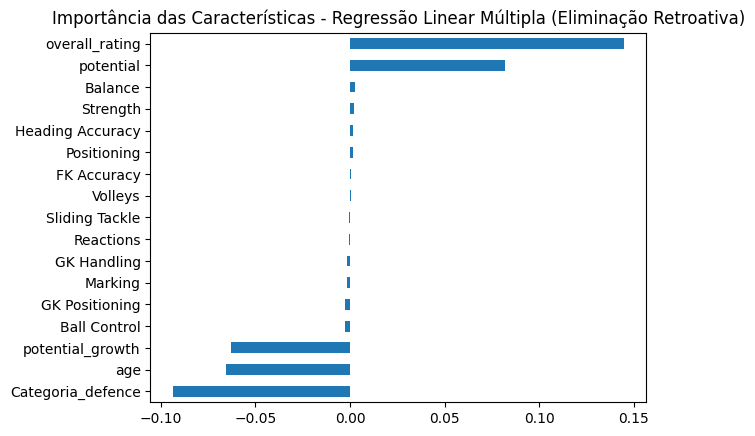

In [148]:
mlr_be_model = sm.OLS(
    y_train, X_train_rlm[mlr_be_selected_features]).fit()

mlr_be_pred = mlr_be_model.predict(
    X_train_rlm[mlr_be_selected_features])

mlr_be_RMSE = np.sqrt(
    mean_squared_error(y_train, mlr_be_pred))

mlr_be_r2 = r2_score(y_train, mlr_be_pred)
mlr_be_adj_r2 = calc_r2_ajustado(X_train_rlm[mlr_be_selected_features],mlr_be_r2)

mlr_be_model.params.sort_values().plot(kind='barh')
plt.title("Importância das Características - Regressão Linear Múltipla (Eliminação Retroativa)")
plt.show()

In [149]:
resultados_modelagem['Regressão Linear Múltipla - Eliminação Retroativa'] = {'rmse':mlr_be_RMSE,
                                                                     'adj. r2':mlr_be_adj_r2}

pd.DataFrame.from_dict(resultados_modelagem,orient='index').sort_values('rmse')

rmse   adj. r2  \
Regressão Linear Múltipla                          0.250560       NaN   
Regressão Linear Múltipla - Eliminação Retroativa  0.252326  0.967028   
baseline model (linear regression)                 0.438973  0.900383   

                                                   r2 ajustado  
Regressão Linear Múltipla                             0.967403  
Regressão Linear Múltipla - Eliminação Retroativa          NaN  
baseline model (linear regression)                         NaN

A regressão linear múltipla usando um conjunto reduzido de características apresenta um RMSE e um R-quadrado ajustado muito semelhantes ao modelo de regressão que incluiu todas as características. Como o desempenho é muito semelhante, mas a complexidade do modelo reduzido é menor, ele deve ser considerado como uma opção melhor.

<a id='ml'></a>
## 2.4 Machine Learning Métodos

Para o pré-processamento dos dados, os atributos numéricos serão escalados usando uma transformação de escore z e o único atributo categórico (position_bucket) será codificado de forma one-hot.

Para este exercício, vamos comparar o desempenho de três modelos de ML:
- Decision trees
- Random forests 
- XGBoost

Para ver qual modelo se sai melhor, utilizaremos validação cruzada com gridsearch CV para ajuste de hiperparâmetros e registraremos o modelo com melhor desempenho.

Usaremos Pipelines do sklearn para dimensionar e processar os dados no formato correto para cada um dos algoritmos de ML. Este é um método mais robusto para preparação de dados e garante repetibilidade entre diferentes modelos.


**Configurar pipelines**

- pré-processamento geral

In [150]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Selecionar os atributos numéricos e categóricos
atributos_numericos = X_train.select_dtypes(include=['int64', 'float64']).columns
atributos_categoricos = X_train.select_dtypes(include=['object']).columns

# Verificar se a soma dos atributos numéricos e categóricos é igual ao número total de colunas
assert len(atributos_numericos.append(atributos_categoricos)) == len(X_train.columns)

# Definir o transformador para os atributos numéricos
transformador_numerico = Pipeline(steps=[
    ('escalonador', StandardScaler())])

# Definir o transformador para os atributos categóricos nominais
transformador_categorico_nominal = Pipeline(steps=[
    ('onehot', OneHotEncoder())])

# Aplicar as transformações aos atributos numéricos e categóricos
preprocessador = ColumnTransformer(
    transformers=[
        ('num', transformador_numerico, atributos_numericos),
        ('cat', transformador_categorico_nominal, atributos_categoricos)])


- pipelines para cada modelo de regressão

In [151]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import xgboost
from xgboost import XGBRegressor

# Pipeline para Decision Tree
pipe_dt = Pipeline(steps=[
    ('preprocessador', preprocessador),
    ('dt', DecisionTreeRegressor(random_state=0))
])

# Pipeline para Decision Tree com PCA
pipe_dt_pca = Pipeline(steps=[
    ('preprocessador', preprocessador),
    ('pca', PCA(n_components=6)),
    ('dt', DecisionTreeRegressor(random_state=0))
])

# Pipeline para Random Forest
pipe_rf = Pipeline([
    ('preprocessador', preprocessador),
    ('rf', RandomForestRegressor(random_state=0))
])

# Pipeline para Random Forest com PCA
pipe_rf_pca = Pipeline([
    ('preprocessador', preprocessador),
    ('pca', PCA(n_components=6)),
    ('rf', RandomForestRegressor(random_state=0))
])

# Pipeline para XGBoost
pipe_xgb = Pipeline([
    ('preprocessador', preprocessador),
    ('xgbrg', XGBRegressor())
])

# Pipeline para XGBoost com PCA
pipe_xgb_pca = Pipeline([
    ('preprocessador', preprocessador),
    ('pca', PCA(n_components=6)),
    ('xgbrg', XGBRegressor())
])


- Métrica

In [152]:
from sklearn.metrics import mean_squared_error

def erro_quadratico_medio_raiz(y_verdadeiro, y_predito):
    """Raiz do erro quadrático médio"""
    return np.sqrt(mean_squared_error(y_verdadeiro, y_predito))


In [153]:
from sklearn.metrics import make_scorer

# Cria um scorer personalizado para o RMSE
rmse_scorer = make_scorer(erro_quadratico_medio_raiz, greater_is_better=False)


- Grid search

In [154]:
CV_FOLDS = 5
N_JOBS = -1
VERBOSE = 1

In [155]:
dt_param_grid = {
    "dt__min_samples_split": [10, 20, 40],
    "dt__max_depth": [2, 6, 8],
    "dt__min_samples_leaf": [20, 40, 100],
    "dt__max_leaf_nodes": [5, 20, 100]
}

# Grid search para Decision Tree
gs_dt = GridSearchCV(estimator=pipe_dt,
                     param_grid=dt_param_grid,
                     scoring=rmse_scorer,
                     n_jobs=N_JOBS,
                     verbose=VERBOSE,
                     cv=CV_FOLDS)

# Grid search para Decision Tree com PCA
gs_dt_pca = GridSearchCV(estimator=pipe_dt_pca,
                         param_grid=dt_param_grid,
                         scoring=rmse_scorer,
                         n_jobs=N_JOBS,
                         verbose=VERBOSE,
                         cv=CV_FOLDS)


In [156]:
rf_param_grid = {
    "rf__min_samples_split": [10, 20, 40],
    "rf__max_depth": [2, 6, 8],
    "rf__min_samples_leaf": [20, 40, 100],
    "rf__max_leaf_nodes": [5, 20, 100]
}

# Grid search para Random Forest
gs_rf = GridSearchCV(estimator=pipe_rf,
                     param_grid=rf_param_grid,
                     scoring=rmse_scorer,
                     n_jobs=N_JOBS,
                     verbose=VERBOSE,
                     cv=CV_FOLDS)

# Grid search para Random Forest com PCA
gs_rf_pca = GridSearchCV(estimator=pipe_rf_pca,
                         param_grid=rf_param_grid,
                         scoring=rmse_scorer,
                         n_jobs=N_JOBS,
                         verbose=VERBOSE,
                         cv=CV_FOLDS)


In [157]:
xgb_param_grid = {
    "xgbrg__n_estimators": [10, 50, 100, 500, 1000],
    "xgbrg__learning_rate": [0.1, 0.5, 1]
}

# Grid search para XGBoost
gs_xgb = GridSearchCV(estimator=pipe_xgb,
                      param_grid=xgb_param_grid,
                      scoring=rmse_scorer,
                      n_jobs=N_JOBS,
                      verbose=VERBOSE,
                      cv=CV_FOLDS)

# Grid search para XGBoost com PCA
gs_xgb_pca = GridSearchCV(estimator=pipe_xgb_pca,
                          param_grid=xgb_param_grid,
                          scoring=rmse_scorer,
                          n_jobs=N_JOBS,
                          verbose=VERBOSE,
                          cv=CV_FOLDS)


- Treino de todos modelos

In [158]:
import joblib

# Lista de grid search para facilitar a iteração
grids = [gs_dt, gs_dt_pca, gs_rf, gs_rf_pca, gs_xgb, gs_xgb_pca]

# Dicionário de grid search e tipos de classificadores para facilitar a referência
grid_dict = {0: 'Decision trees', 1: 'Decision trees com PCA', 
             2: 'Random forests', 3: 'Random forests com PCA', 
             4: 'XGBoost', 5: 'XGBoost com PCA'}

# Ajuste dos objetos grid search
print('Realizando otimização dos modelos...')
melhor_rmse = 1.0
melhor_modelo = 0
melhor_gs = ''

for idx, gs in enumerate(grids):
    print(f"\nEstimador: {grid_dict[idx]}")
    # Ajuste do grid search
    gs.fit(X_train, y_train)
    # Melhores parâmetros
    print(f"Melhores parâmetros: {gs.best_params_}")
    # Melhor precisão nos dados de treinamento
    print(f"Melhor precisão nos dados de treinamento: {-gs.best_score_}")
    # Previsão nos dados de teste com os melhores parâmetros
    y_pred = gs.predict(X_test)
    # Precisão nos dados de teste do modelo com os melhores parâmetros
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE do melhor modelo {grid_dict[idx]} em todos os dados de treinamento: {rmse}")
    # Adicionar resultado ao dicionário de resultados do modelo
    r2 = r2_score(y_test,y_pred)
    resultados_modelagem[grid_dict[idx]]= {'rmse': rmse,
                                    'adj. r2': calc_r2_ajustado(X_test,r2)}

    # Acompanhar o melhor modelo (maior precisão nos dados de teste)
    if rmse < melhor_rmse:
        melhor_rmse = rmse
        melhor_gs = gs
        melhor_modelo = idx
        print(f"\nClassificador com melhor precisão nos dados de teste: {grid_dict[melhor_modelo]}")

# Salvar a melhor pipeline do grid search em um arquivo
arquivo_dump = 'melhor_modelo_gs.pkl'
joblib.dump(melhor_gs, arquivo_dump, compress=1)
print(f"\nA pipeline do grid search do modelo {grid_dict[melhor_modelo]} foi salva no arquivo: {arquivo_dump}")


Realizando otimização dos modelos...

Estimador: Decision trees
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Melhores parâmetros: {'dt__max_depth': 8, 'dt__max_leaf_nodes': 100, 'dt__min_samples_leaf': 20, 'dt__min_samples_split': 10}
Melhor precisão nos dados de treinamento: 0.21243480848909924
RMSE do melhor modelo Decision trees em todos os dados de treinamento: 0.19835021120819987

Classificador com melhor precisão nos dados de teste: Decision trees

Estimador: Decision trees com PCA
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Melhores parâmetros: {'dt__max_depth': 8, 'dt__max_leaf_nodes': 100, 'dt__min_samples_leaf': 20, 'dt__min_samples_split': 10}
Melhor precisão nos dados de treinamento: 0.5484091905766262
RMSE do melhor modelo Decision trees com PCA em todos os dados de treinamento: 0.547809793061603

Estimador: Random forests
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Melhores parâmetros: {'rf__max_depth': 8, 'rf__max_leaf

In [159]:
display(HTML("<h4>Resultados dos modelos</h4>"))
pd.DataFrame.from_dict(resultados_modelagem,orient='index')

rmse   adj. r2  \
baseline model (linear regression)                 0.438973  0.900383   
Regressão Linear Múltipla                          0.250560       NaN   
Regressão Linear Múltipla - Eliminação Retroativa  0.252326  0.967028   
Decision trees                                     0.198350  0.979204   
Decision trees com PCA                             0.547810  0.841375   
Random forests                                     0.163438  0.985881   
Random forests com PCA                             0.418493  0.907426   
XGBoost                                            0.083435  0.996320   
XGBoost com PCA                                    0.274913  0.960051   

                                                   r2 ajustado  
baseline model (linear regression)                         NaN  
Regressão Linear Múltipla                             0.967403  
Regressão Linear Múltipla - Eliminação Retroativa          NaN  
Decision trees                                             NaN  
Decision trees com PCA                                     NaN  
Random forests                                             NaN  
Random forests com PCA                                     NaN  
XGBoost                                                    NaN  
XGBoost com PCA                                            NaN

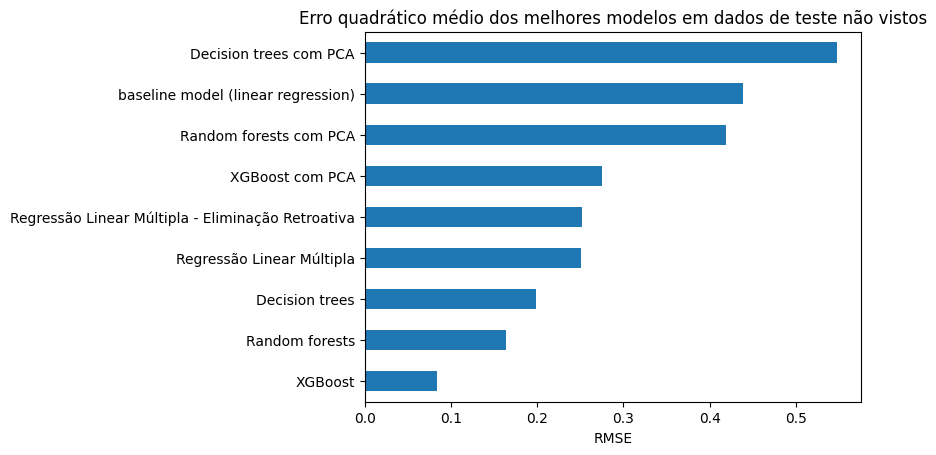

In [160]:
pd.DataFrame.from_dict(resultados_modelagem, orient='index')['rmse'].sort_values().plot(kind='barh')
plt.title("Erro quadrático médio dos melhores modelos em dados de teste não vistos")
plt.xlabel("RMSE")
plt.show()

O XGBoost teve o melhor desempenho entre todos os modelos, com um erro quadrático médio de 0.079 nos dados de teste completamente não vistos.

Isso representa uma grande melhoria em relação ao modelo de regressão inicial e aos modelos de regressão linear múltipla. Vamos usar o modelo XGBoost como candidato para investigações adicionais.

<a id='mi'></a>
# 3. Interpretação do Modelo

In [161]:
import joblib

#Carregar o melhor modelo
melhor_modelo = joblib.load("melhor_modelo_gs.pkl")
print(f"\nMelhores parâmetros:\n\t{melhor_modelo.best_params_}")



Melhores parâmetros:
	{'xgbrg__learning_rate': 0.1, 'xgbrg__n_estimators': 1000}


O modelo atualmente está armazenado como um objeto de pipeline do scikit-learn. As bibliotecas xgboost e SHAP atualmente não suportam este tipo de objeto, portanto, vamos treinar novamente o modelo usando os melhores parâmetros manualmente e armazená-lo como um objeto de modelo xgboost.

In [162]:
#create training dataset
X_train_shap = X_train.copy()
X_train_shap = pd.get_dummies(X_train_shap,drop_first=True)

scaler = StandardScaler().fit(X_train_shap[atributos_numericos])
X_train_shap[atributos_numericos] = scaler.transform(X_train_shap[atributos_numericos])


#create test dataset
X_test_shap = X_test.copy()
X_test_shap = pd.get_dummies(X_test_shap,drop_first=True)
#use scaler from training set
X_test_shap[atributos_numericos] = scaler.transform(X_test_shap[atributos_numericos])


#train model
xgb_model = XGBRegressor(learning_rate= 0.1, 
                              n_estimators= 1000).fit(X_train_shap,y_train)

Para avaliar a importância das características para o modelo XGBoost, podemos usar a função embutida plot_importances. Na documentação, existem três maneiras diferentes de calcular a importância das características:

- ”weight” é o número de vezes que uma característica aparece em uma tree
- ”gain” é o ganho médio das divisões que usam a característica
- ”cover” é a cobertura média das divisões que usam a característica, onde a cobertura é definida como o número de amostras afetadas pela divisão

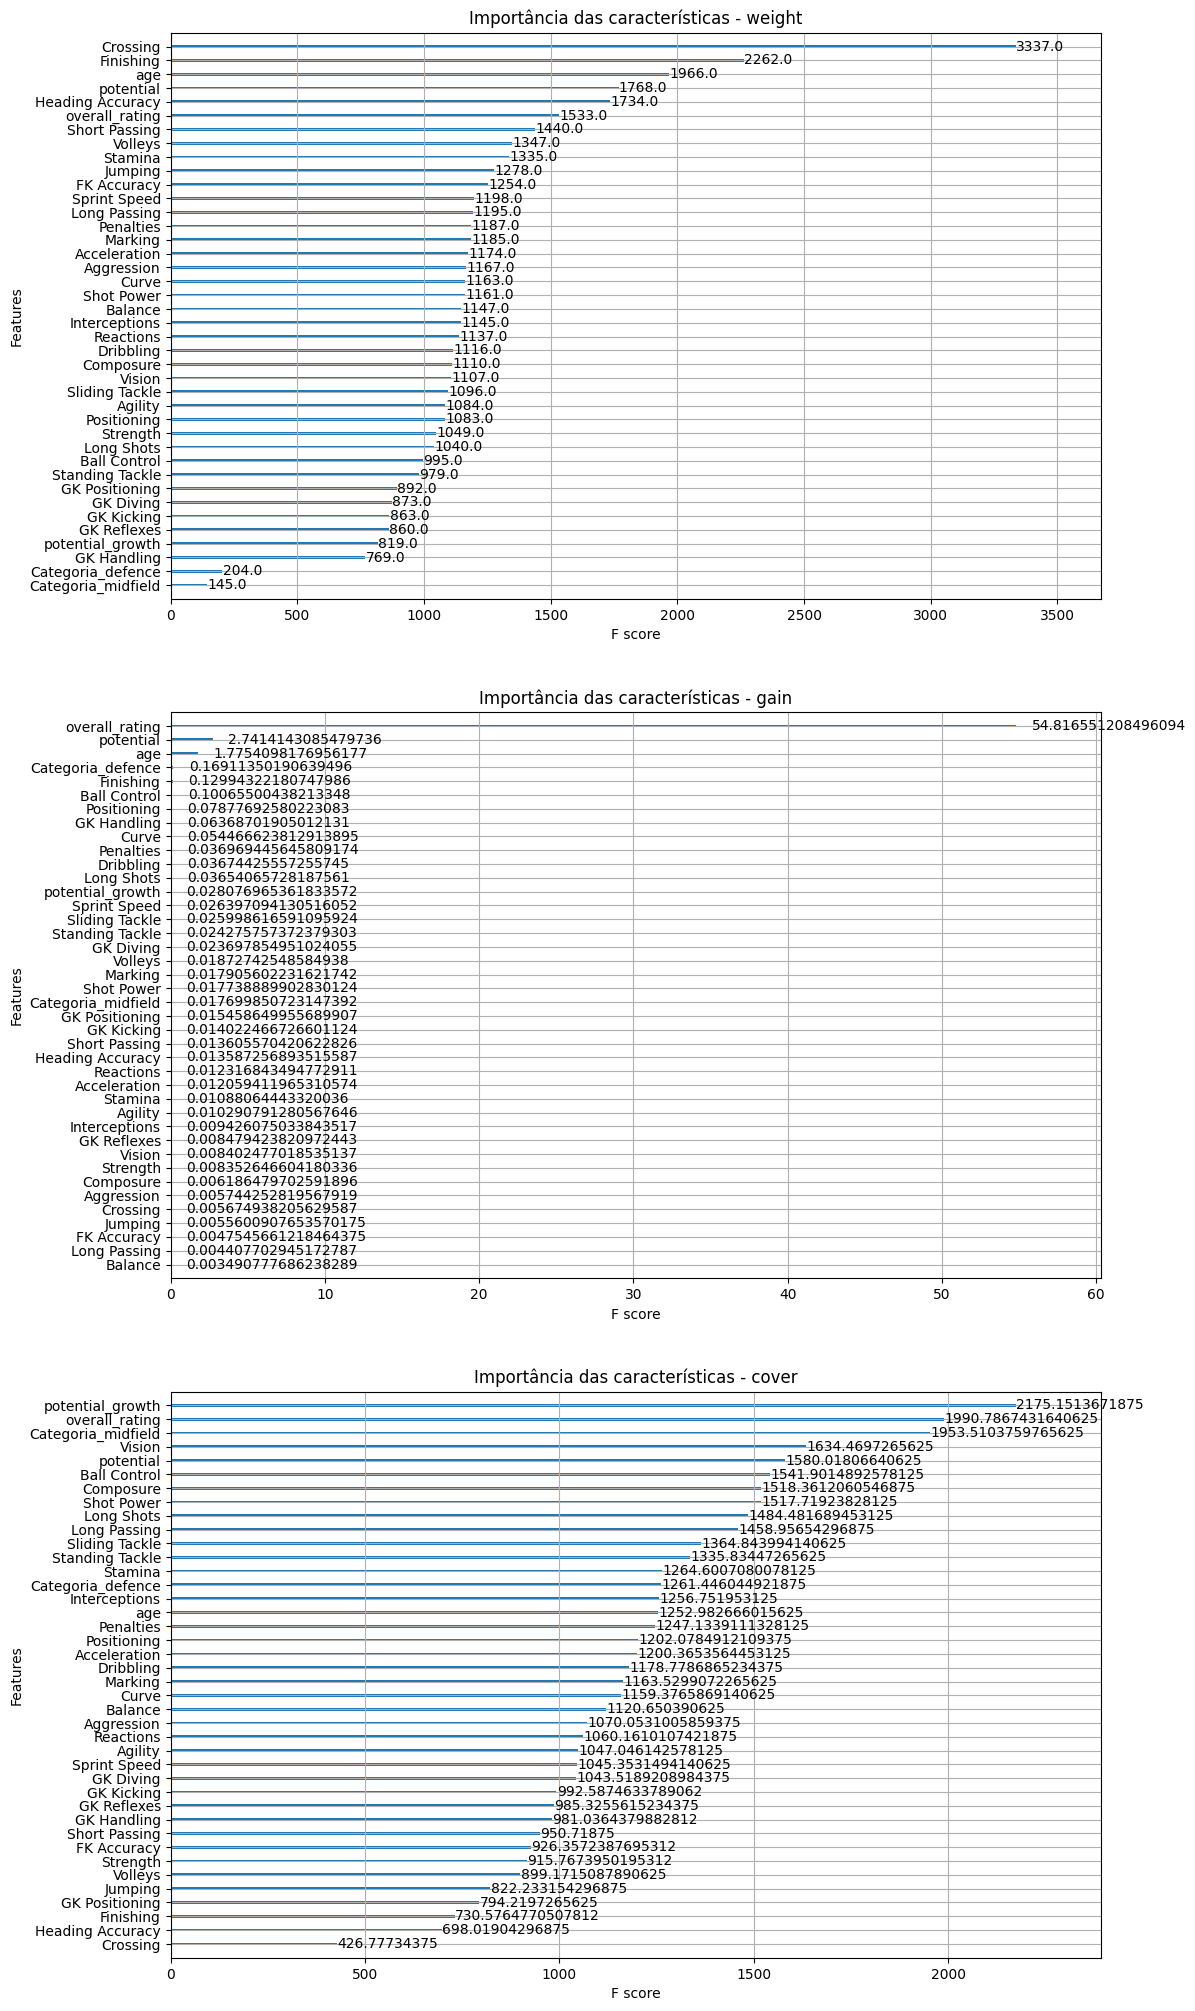

In [163]:
fig, ax = plt.subplots(nrows=3, figsize=(12, 25))

for idx, importance_type in enumerate(['weight', 'gain', 'cover']):
    xgboost.plot_importance(xgb_model, importance_type=importance_type, ax=ax[idx])
    ax[idx].set_title(f"Importância das características - {importance_type}")

plt.show()

A importância das características para cada método é muito diferente, o que não inspira muita confiança na interpretação correta das características mais importantes.

Um método melhor é usar os valores SHAP, que fornecem mais insights sobre como cada característica afeta a saída do modelo. Em vez de usar gráficos de barras de importância de características, podemos usar um gráfico de dispersão de densidade dos valores SHAP para cada característica. Isso nos permite identificar quanto impacto cada característica tem na saída do modelo para os pontos de dados no conjunto de teste. As características são ordenadas pela soma das magnitudes dos valores SHAP em todas as amostras.

Observe que quando os pontos de dispersão não cabem em uma linha, eles se acumulam para mostrar a densidade, e a cor de cada ponto representa o valor relativo da característica desse ponto de dados.

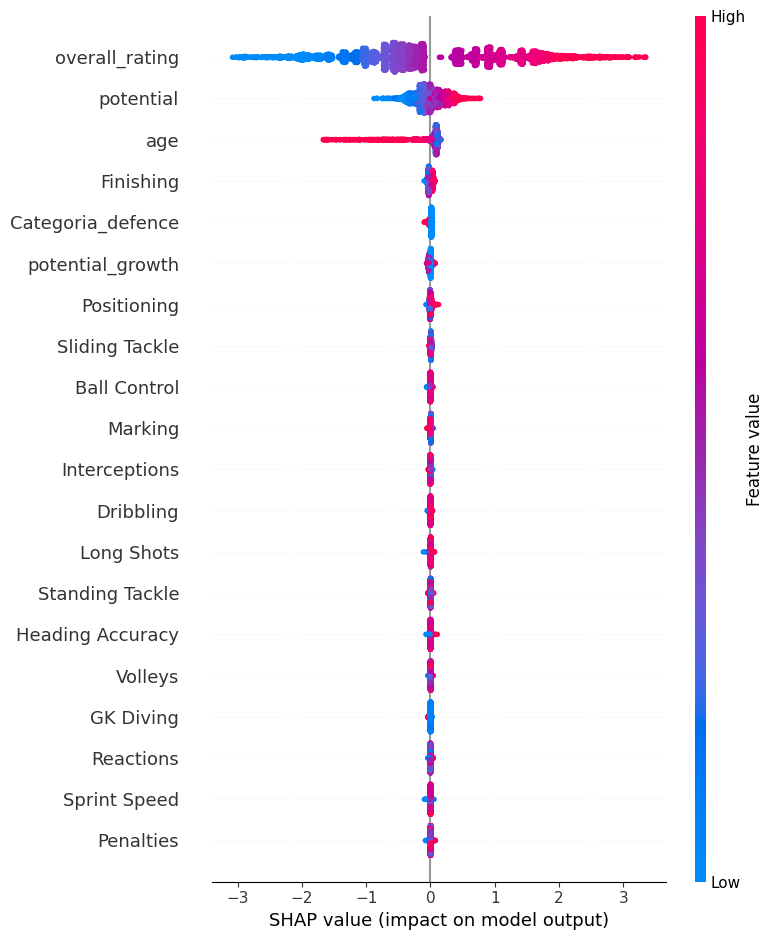

In [164]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_shap)

display(HTML("<h4>Importância das características do modelo XGBoost - Gráfico de resumo de valores SHAP</h4>"))

#plotar um resumo
shap.summary_plot(shap_values, X_test_shap)

A partir do gráfico de resumo acima, podemos ver que a classificação geral, o potencial e a idade têm o maior impacto na saída do modelo. Como esperado, ter uma classificação geral e um potencial mais altos aumenta o valor do jogador. Curiosamente, podemos ver que, para a maioria dos pontos de dados, a idade não tem um grande impacto, mas para aqueles pontos de dados em que é importante, começa a ter um grande efeito negativo na previsão final. A barra de cores mostra que quanto maior a idade (pontos de dados vermelhos), maior é o impacto negativo.

Olhando mais para baixo no gráfico, vemos que os atributos individuais do jogador não contribuem significativamente para a saída do modelo. Também podemos ver que a posição do jogador não tem um efeito material na saída do modelo. Presumivelmente, porque a posição do jogador é inferida pelas forças e fraquezas relativas em seus atributos de jogo.

Manter todos esses atributos do jogador no modelo aumenta a complexidade, mas sem adicionar poder preditivo significativo. Acredito que ainda há informações importantes contidas nesses recursos, então eles não devem ser descartados completamente. Portanto, vou resumir os atributos em categorias mais gerais (por exemplo, habilidades de ataque, habilidades de defesa etc.) para manter algumas das informações importantes sobre cada jogador, mas reduzir a dimensionalidade do conjunto de dados.

<a id='fe'></a>
### 3.1 Engenharia de Características

- Combinando os atributos de jogo em categorias gerais
    - Calculando a pontuação média dos atributos dentro de cada categoria.

In [165]:
skills_dict = {
    'Attacking': ['Crossing', 'Finishing', 'Heading Accuracy', 'Short Passing', 'Volleys'],
    'Skills': ['Dribbling', 'Curve', 'FK Accuracy', 'Long Passing', 'Ball Control'],
    'Movement': ['Acceleration', 'Sprint Speed', 'Agility', 'Reactions', 'Balance'],
    'Power': ['Shot Power', 'Jumping', 'Stamina', 'Strength', 'Long Shots'],
    'Mentality': ['Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure'],
    'Defending': ['Standing Tackle', 'Sliding Tackle', 'Marking'],
    'Goalkeeping': ['GK Diving', 'GK Handling', 'GK Kicking', 'GK Positioning', 'GK Reflexes']
}

In [166]:
# Função para criar novos atributos a partir dos dados brutos
def make_fe_data_set(skills_dict=skills_dict):
    """Crie um conjunto de dados com recursos projetados (consolide os atributos individuais do jogador)"""
    
    # Carregue os dados brutos
    raw_df = pd.read_csv("dados/dadosprocessados/dados_limpos.csv")    
    df = raw_df.loc[raw_df['value_clean']!=0].copy() # exclua as linhas com 0 na coluna value_clean

    # Selecione recursos sensíveis
    df = df[ATRIBUTOS + ['age','overall_rating','potential','Position','value_clean']].copy()
    
   
    # Exclua pontos de dados de posição ausentes
    df = df.loc[df['Position'].notnull()].copy()
    
    # Crie buckets de posição do jogador
    df['Categoria'] = df['Position'].apply(agrupar_posicoes)
    del df['Position']
    
    # Crie um novo atributo para o crescimento potencial
    df['crescimento_potencial'] = df['potential'] - df['overall_rating']
    
    
    # Combine recursos de atributo
    for skill_cat, skills in skills_dict.items():
        df[skill_cat] = df[skills].mean(axis=1)
    
    # Transformação logarítmica no atributo value_clean
    df['alvo'] = np.log(df['value_clean'])
    del df['value_clean']
    
    
    keep_cols = [col for col in df.columns if col not in ATRIBUTOS ]
    df = df[keep_cols].copy()
    
    # Garanta que não haja dados ausentes
    assert df.isnull().sum().sum() == 0
    
    # Embaralhe o dataframe apenas no caso de haver algum viés na ordem em que os dados foram coletados
    df_shuffled = shuffle(df, random_state=0)


    # Crie divisão de treino e teste
    return train_test_split(df_shuffled.iloc[:,:-1],
                            df_shuffled.iloc[:,-1],
                            test_size=0.33,
                            random_state=0)


- Crie conjuntos de dados com engenharia de recursos (fe)

In [167]:
X_train_fe,X_test_fe,y_train_fe,y_test_fe = make_fe_data_set()

In [168]:
#Novo conjunto de dados para modelagem
X_train_fe.head()

age  overall_rating  potential Categoria  crescimento_potencial  \
104     18              66         82  midfield                     16   
3367    31              76         76  midfield                      0   
4816    21              67         75  midfield                      8   
11395   24              59         65  midfield                      6   
11263   24              60         64  midfield                      4   

       Attacking  Skills  Movement  Power  Mentality  Defending  Goalkeeping  
104         51.8    61.4      72.0   55.6  54.666667  41.000000          9.8  
3367        68.6    77.8      76.0   71.6  67.333333  27.666667          9.6  
4816        61.8    61.8      68.2   65.8  55.500000  31.000000          9.6  
11395       48.4    54.4      71.2   52.8  50.500000  27.666667          9.8  
11263       52.0    56.2      64.8   57.0  46.833333  37.333333         11.2

- Pré-processar os dados

In [169]:
# Recursos numéricos são as colunas de X_train_fe que têm tipos de dados inteiros ('int64') e de ponto flutuante ('float64').
numeric_features = X_train_fe.select_dtypes(include=['int64', 'float64']).columns

# Recursos categóricos são as colunas de X_train_fe que têm tipos de dados do tipo objeto ('object').
recursos_categoricos = X_train_fe.select_dtypes(include=['object']).columns

# Aplicando a padronização aos recursos numéricos
scaler = StandardScaler().fit(X_train_fe[numeric_features])
X_train_fe[numeric_features] = scaler.transform(X_train_fe[numeric_features])

# Convertendo os recursos categóricos em variáveis dummy
X_train_fe = pd.get_dummies(X_train_fe, drop_first=True)


- Retreinar o modelo

In [170]:
parametros_grade = {
    "n_estimators": [10, 50, 100, 500, 1000],
    "learning_rate": [0.1, 0.5, 1]
}

xgb_modelo_fe = GridSearchCV(XGBRegressor(random_state=0), cv=CV_FOLDS, 
                    param_grid=parametros_grade,
                    n_jobs=N_JOBS, verbose=VERBOSE)

xgb_modelo_fe.fit(X_train_fe, y_train_fe)


Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...ne,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=0, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.5, 1],
                         'n_estimators': [10, 50, 100, 500, 1000]},
             verbose=1)

- Fazer previsões no conjunto de teste

In [171]:
#Criar conjunto de teste
#Aplicar o scaler do conjunto de treinamento ao conjunto de teste
X_test_fe[numeric_features] = scaler.transform(X_test_fe[numeric_features]) 
X_test_fe = pd.get_dummies(X_test_fe,drop_first=True)

{'learning_rate': 0.1, 'n_estimators': 500}
RMSE: 0.08340332960300176


rmse   adj. r2  \
XGBoost FE                                         0.083403  0.996343   
XGBoost                                            0.083435  0.996320   
Random forests                                     0.163438  0.985881   
Decision trees                                     0.198350  0.979204   
Regressão Linear Múltipla                          0.250560       NaN   
Regressão Linear Múltipla - Eliminação Retroativa  0.252326  0.967028   
XGBoost com PCA                                    0.274913  0.960051   
Random forests com PCA                             0.418493  0.907426   
baseline model (linear regression)                 0.438973  0.900383   
Decision trees com PCA                             0.547810  0.841375   

                                                   r2 ajustado  
XGBoost FE                                                 NaN  
XGBoost                                                    NaN  
Random forests                                             NaN  
Decision trees                                             NaN  
Regressão Linear Múltipla                             0.967403  
Regressão Linear Múltipla - Eliminação Retroativa          NaN  
XGBoost com PCA                                            NaN  
Random forests com PCA                                     NaN  
baseline model (linear regression)                         NaN  
Decision trees com PCA                                     NaN

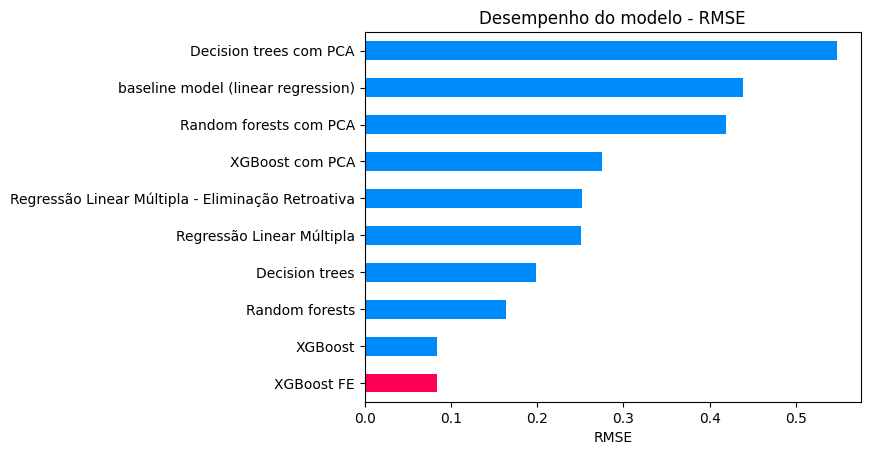

In [172]:
xgb_fe_predict = xgb_modelo_fe.predict(X_test_fe)

xgb_fe_RMSE = np.sqrt(mean_squared_error(y_test_fe, xgb_fe_predict))

print(xgb_modelo_fe.best_params_)
print(f"RMSE: {xgb_fe_RMSE}")

resultados_modelagem['XGBoost FE'] = {'rmse':xgb_fe_RMSE,
                              'adj. r2':calc_r2_ajustado(X_test_fe,r2_score(y_test_fe,xgb_fe_predict))}

display(pd.DataFrame.from_dict(resultados_modelagem,orient='index').sort_values('rmse'))
pd.DataFrame.from_dict(resultados_modelagem,orient='index').sort_values('rmse')['rmse'].plot(kind='barh',
                                                                                      color=['#ff0055'] + ['#008bfb']*9)
plt.title("Desempenho do modelo - RMSE")
plt.xlabel("RMSE")
plt.show()

Reduzir o espaço de características realmente aumentou (marginalmente) o desempenho do modelo, ao mesmo tempo em que reduziu a complexidade.

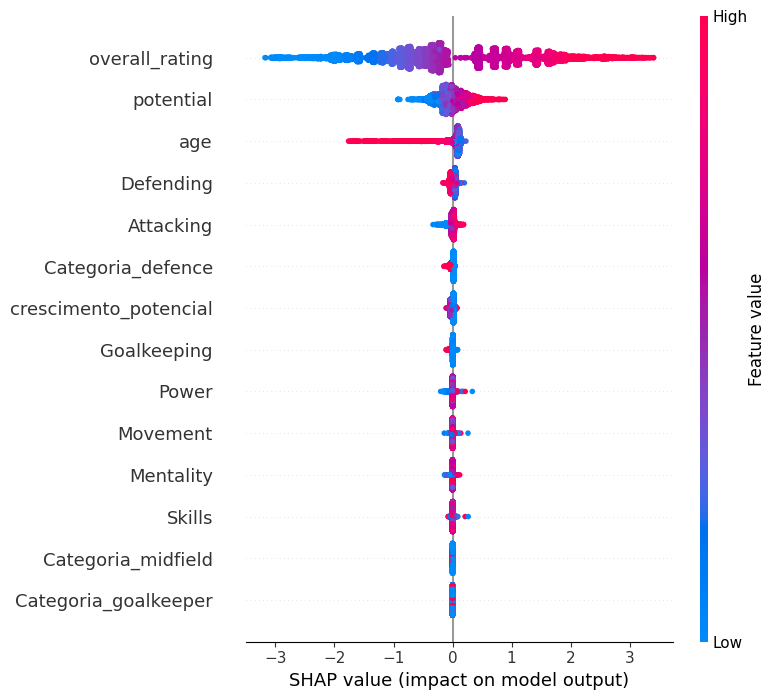

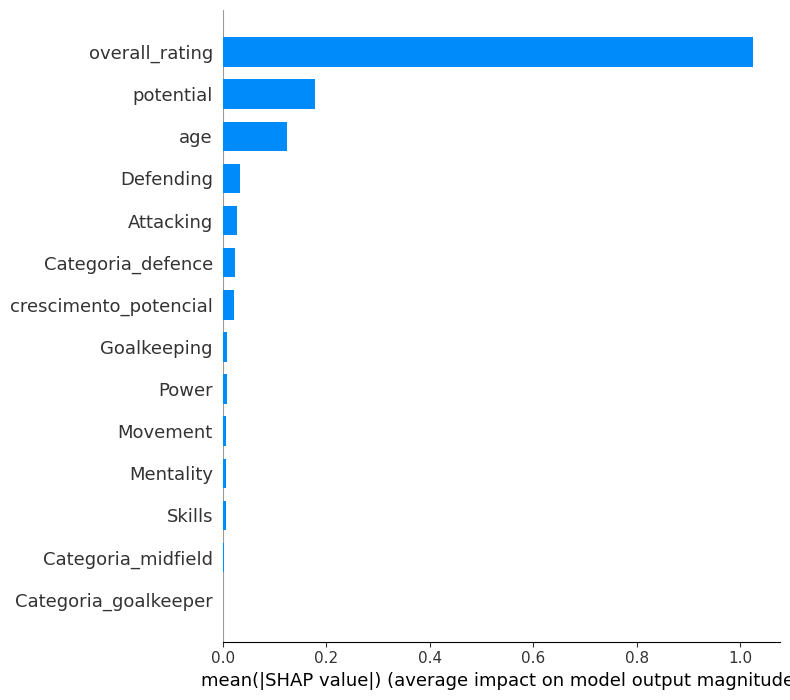

In [173]:
import shap

# Valores SHAP
explainer_fe = shap.TreeExplainer(xgb_modelo_fe.best_estimator_)
shap_values_fe = explainer_fe.shap_values(X_train_fe)

# Plotar um resumo
shap.summary_plot(shap_values_fe, X_train_fe)

# Resumo como um gráfico de barras
shap.summary_plot(shap_values_fe, X_train_fe, plot_type="bar")

Mais uma vez, a classificação geral, o potencial e a idade têm os maiores efeitos na saída do modelo. Ao agrupar os atributos de jogo em categorias mais gerais, podemos ver que cada categoria tem um efeito geralmente maior na saída do modelo em comparação com quando os atributos individuais foram usados.

A característica de engenharia do potencial de crescimento também é um pouco importante, com jogadores que têm um potencial de crescimento mais alto demandando valorações premium.

Interessantemente, podemos ver que os atributos de ataque são importantes para melhorar o valor de um jogador, especialmente se o jogador tiver habilidades de ataque pobres.

Para investigar o efeito de cada recurso na saída do modelo mais a fundo, podemos plotar o valor SHAP versus cada recurso (observe que os valores dos recursos foram dimensionados).

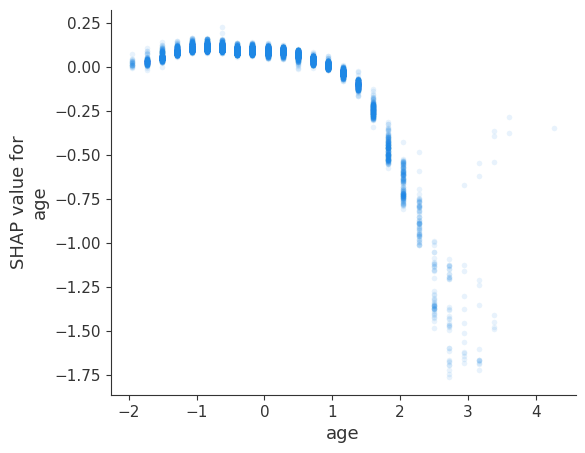

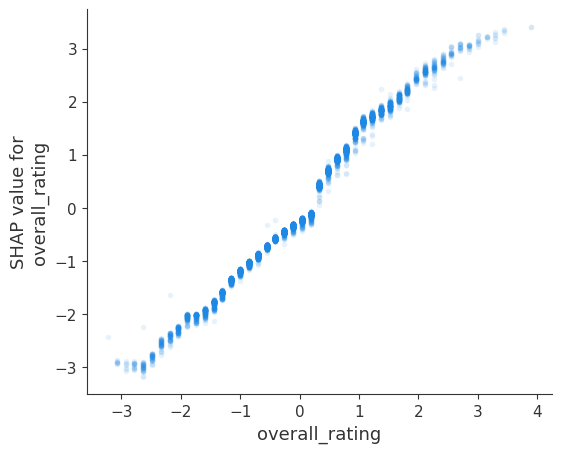

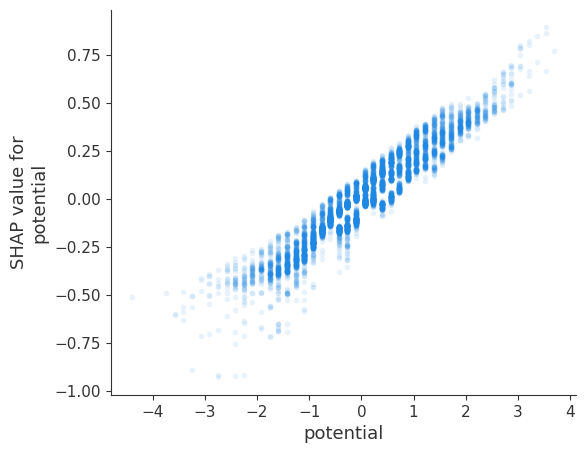

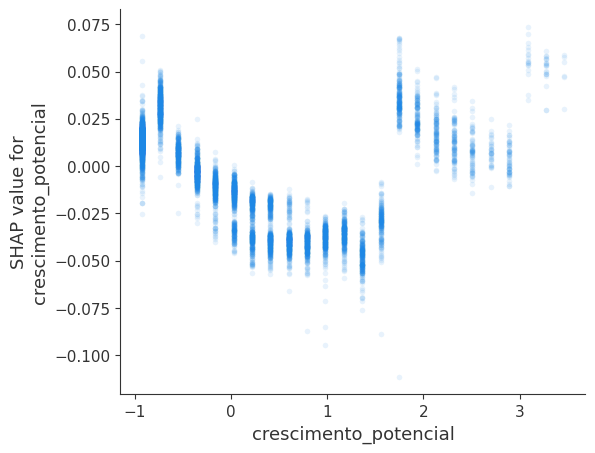

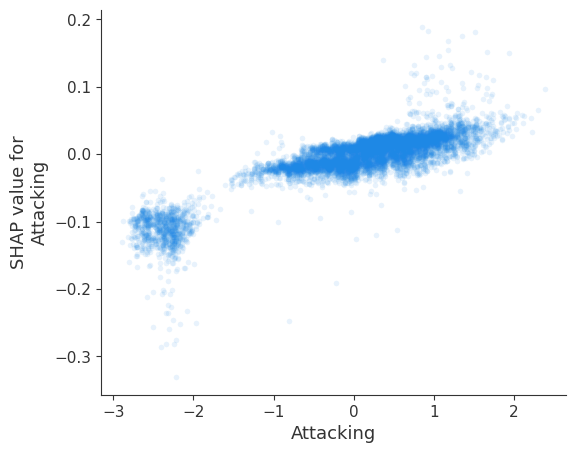

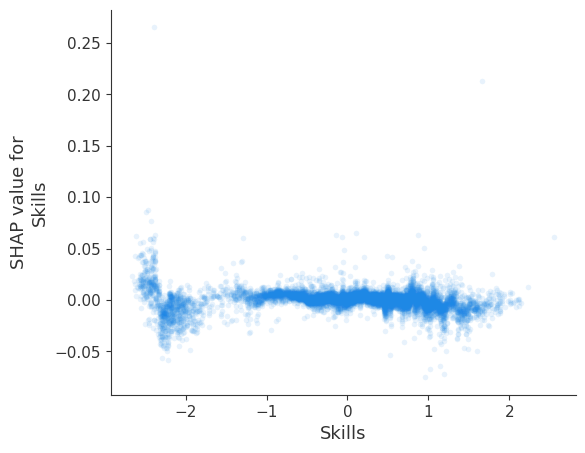

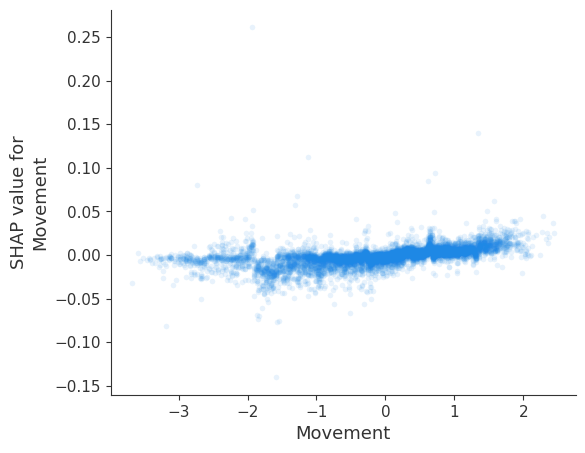

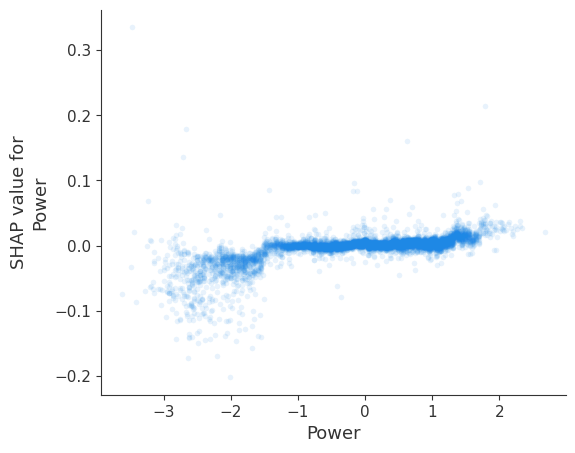

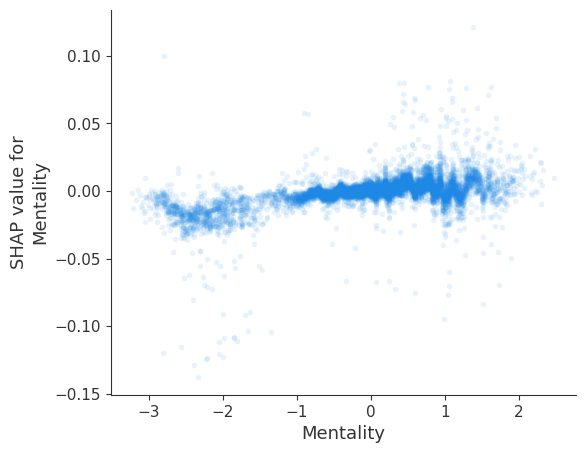

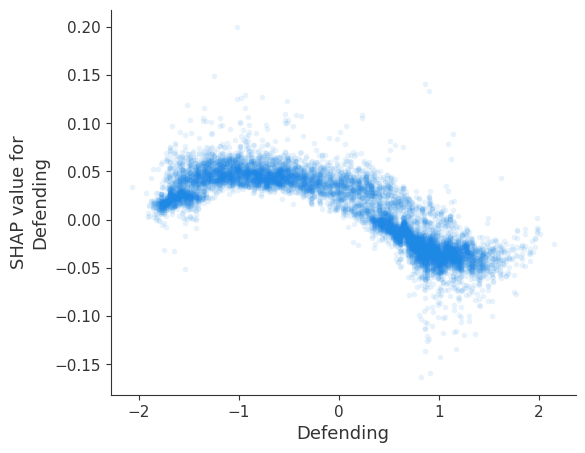

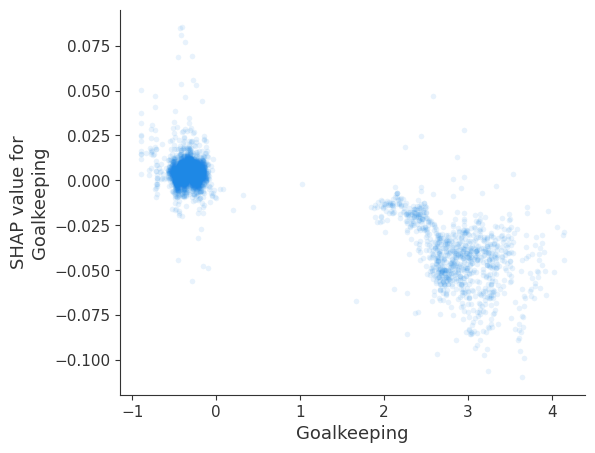

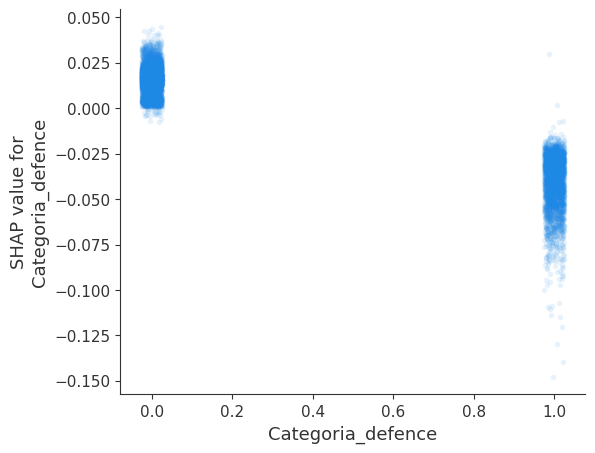

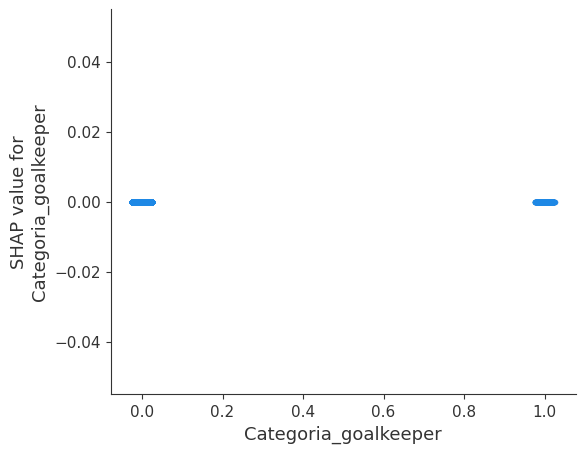

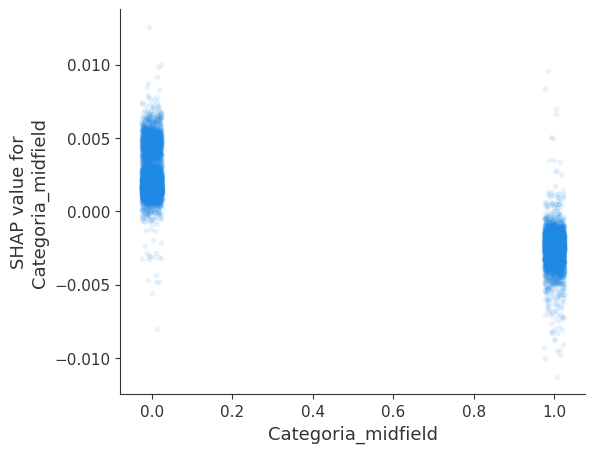

In [174]:
for name in X_train_fe.columns:
    if name in X_train_fe[numeric_features]:
        shap.dependence_plot(name, 
                             shap_values_fe, 
                             X_train_fe,
                             interaction_index=None,
                             alpha=0.1)
    else:
        shap.dependence_plot(name, 
                             shap_values_fe, 
                             X_train_fe,
                             interaction_index=None,
                             alpha=0.1,
                             x_jitter=0.05)

<a id='iovp'></a>
# 4. Identificando jogadores supervalorizados/subvalorizados

Podemos usar o modelo para ajudar a identificar jogadores que estão supervalorizados ou subvalorizados no mercado.

- Retreinar o modelo no conjunto de dados completo e comparar os valores reais e previstos dos jogadores.

In [175]:
caracteristicas_dados_completos = X_test_fe._append(X_train_fe)
alvo_dados_completos = y_test_fe._append(y_train_fe)

assert len(caracteristicas_dados_completos) == len(alvo_dados_completos)

In [176]:
params = xgb_modelo_fe.best_params_

final_model = XGBRegressor(learning_rate = 0.1,
                           n_estimators = 1000).fit(caracteristicas_dados_completos,alvo_dados_completos)

In [177]:
dump_file = 'modelo_final.pkl'
joblib.dump(final_model, dump_file, compress=1)
print(f"Salvo o melhor modelo em: {dump_file}")

Salvo o melhor modelo em: modelo_final.pkl


In [178]:
final_model = joblib.load('modelo_final.pkl')

- Adicione de volta os nomes dos jogadores ao conjunto de dados para ajudar a identificar jogadores que estão sub ou supervalorizados de acordo com o modelo.

In [179]:
df_analise_predicoes = raw_df[['name','country','age','overall_rating','Position','value_clean']]
df_analise_predicoes['Position'] = df_analise_predicoes['Position'].apply(agrupar_posicoes)
df_analise_predicoes = df_analise_predicoes.dropna()

assert df_analise_predicoes.isnull().sum().sum() == 0

- Adicionando as previsões ao DataFrame.

In [180]:
#Fazendo as previsões finais no DataFrame reordenado.
previsoes_finais = final_model.predict(caracteristicas_dados_completos.sort_index())


df_analise_predicoes['predicted_value'] = np.exp(previsoes_finais)
df_analise_predicoes['difference'] = df_analise_predicoes['value_clean']-df_analise_predicoes['predicted_value']
df_analise_predicoes['difference_pct'] = (df_analise_predicoes['difference']/df_analise_predicoes['value_clean'])*100

In [181]:
df_analise_predicoes.float_format = '{:,.0f}'.format
df_analise_predicoes.head()

name    country  age  overall_rating    Position  \
0        Dayotchanculle Upamecano     France   19              77     defence   
1       Renato Júnior Luz Sanches   Portugal   20              75    midfield   
2               Juan Marcos Foyth  Argentina   20              74     defence   
3                 Wuilker Faríñez  Venezuela   20              73  goalkeeper   
4  Thiago Alcântara do Nascimento      Spain   27              87    midfield   

   value_clean  predicted_value  difference  difference_pct  
0   13000000.0       12962253.0     37747.0        0.290362  
1   10000000.0       10049386.0    -49386.0       -0.493860  
2    8500000.0        8493908.0      6092.0        0.071671  
3    7500000.0        7464623.5     35376.5        0.471687  
4   51500000.0       51724304.0   -224304.0       -0.435542

### Identificando jogadores supervalorizados

Especificamente, vamos analisar jogadores que estão supervalorizados na Inglaterra.

In [182]:
def obter_principais_discrepancias_jogador(method, df=df_analise_predicoes, n=10):
    """Obter os principais jogadores com discrepância relativa entre valor real e previsto
    
    method = 'abaixo' ou 'acima'
    n = int, número de jogadores para retornar
    
    """
    assert method in ['undervalued', 'overvalued']
    
    if method == 'undervalued':
        return df.nsmallest(n, 'difference_pct')
    else:
        return df.nlargest(n, 'difference_pct')

In [183]:
#Pegando os top 10 jogadores supervalorizados
display(HTML("<h3>Top 10 jogadores supervalorizados da Inglaterra</h3>"))
obter_principais_discrepancias_jogador('overvalued', df=df_analise_predicoes.loc[(df_analise_predicoes['country']=='England')&
                                                             (df_analise_predicoes['value_clean']>20_000)])

name  country  age  overall_rating  Position  \
4983         Jake Livermore  England   28              73  midfield   
13129        Scott Wagstaff  England   28              65  midfield   
12184       George Honeyman  England   23              67  midfield   
5331            Levi Sutton  England   21              60   defence   
12245  Christopher Hamilton  England   23              66   defence   
12855            Tommy Rowe  England   29              67  midfield   
11423           Matt Crooks  England   24              65  midfield   
1364              Luke Amos  England   21              64  midfield   
7945             Louis Reed  England   20              65  midfield   
10562            Tom Conlon  England   22              62  midfield   

       value_clean  predicted_value    difference  difference_pct  
4983     4000000.0     3.688581e+06  311419.25000        7.785481  
13129     550000.0     5.170378e+05   32962.15625        5.993119  
12184    1100000.0     1.035242e+06   64757.50000        5.887045  
5331      290000.0     2.735578e+05   16442.25000        5.669741  
12245     925000.0     8.736359e+05   51364.12500        5.552878  
12855     750000.0     7.090381e+05   40961.93750        5.461592  
11423     700000.0     6.626879e+05   37312.06250        5.330295  
1364      725000.0     6.867411e+05   38258.93750        5.277095  
7945      825000.0     7.846164e+05   40383.56250        4.894977  
10562     400000.0     3.810308e+05   18969.21875        4.742305

[Jake Livermore](https://en.wikipedia.org/wiki/Jake_Livermore) é o jogador inglês mais sobrevalorizado no conjunto de dados, com um prêmio de 25% em relação ao seu valor previsto de €369.000. Ele é meio-campista do Watford, que atualmente está na EFL. Anteriormente, ele jogou por times da Premiership como Tottenham Hotspur,  Derby County, Leeds United e Hull City. Talvez sua reputação de jogar nesses grandes clubes tenha levado à supervalorização de seu perfil de habilidades/idade.

Mais uma vez podemos usar valores SHAP para investigar como o modelo chegou à sua previsão:

In [188]:
#shap values
explainer_fe = shap.TreeExplainer(final_model)
shap_values_full = explainer_fe.shap_values(caracteristicas_dados_completos.sort_index())

In [190]:
def previsao_investigativa(index,name):
    display(HTML(f"<h4>{name} Previsão - valores SHAP </h4>"))
    display(shap.force_plot(explainer_fe.expected_value,
                            shap_values_full[(np.where(caracteristicas_dados_completos.sort_index().index==index)[0]),:],
                            caracteristicas_dados_completos.columns))
    

previsao_investigativa(6206,"Jake Livermore")

Idade, classificação geral, potencial e habilidades defensivas tiveram um impacto negativo em sua valuation prevista. O gráfico de força SHAP mostra que não houve características significativas que ajudassem a aumentar sua valuation.

Notavelmente, Adebayo Akinfenwa também está na lista de sobrevalorizados. Os fãs de FIFA podem saber que ele tem uma base de fãs cult no jogo (e na vida real), mesmo jogando apenas por um clube de uma liga inferior, devido ao seu físico incomum (maior) em comparação com um jogador de futebol típico. Sua reputação popular entre os fãs e a mídia pode estar inflacionando sua valuation.

In [191]:
#Investigar a previsão de Adebayo Akinfenwa em mais detalhes
previsao_investigativa(1600,"Adebayo Akinfenwa")

### Identificar jogadores subvalorizados

In [193]:
# Obter os 10 principais jogadores subvalorizados
display(HTML("<h3>Top 10 jogadores subvalorizados da Inglaterra</h3>"))
obter_principais_discrepancias_jogador('undervalued', df=df_analise_predicoes.loc[(df_analise_predicoes['country'] == 'England') &
                                                                       (df_analise_predicoes['value_clean'] > 20_000)])

name  country  age  overall_rating  Position  value_clean  \
6291   Elliott Bennett  England   29              68  midfield     675000.0   
4183      Daniel Batty  England   20              65  midfield     925000.0   
8827        Paul Digby  England   23              63  midfield     400000.0   
2564      Joe Williams  England   21              70  midfield    2400000.0   
13103      Matty Blair  England   29              65  midfield     400000.0   
12891  George Francomb  England   26              63  midfield     325000.0   
11552       Tom Naylor  England   27              66  midfield     600000.0   
3967         Max Power  England   24              68  midfield    1000000.0   
2263       Luke O'Nien  England   23              66  midfield     750000.0   
3266      Jamie Hanson  England   22              65  midfield     675000.0   

       predicted_value    difference  difference_pct  
6291      7.161116e+05  -41111.56250       -6.090602  
4183      9.812159e+05  -56215.93750       -6.077399  
8827      4.240191e+05  -24019.09375       -6.004773  
2564      2.534820e+06 -134820.00000       -5.617500  
13103     4.224168e+05  -22416.78125       -5.604195  
12891     3.430326e+05  -18032.59375       -5.548490  
11552     6.321531e+05  -32153.06250       -5.358844  
3967      1.050983e+06  -50982.75000       -5.098275  
2263      7.866342e+05  -36634.18750       -4.884558  
3266      7.067292e+05  -31729.25000       -4.700630

In [194]:
previsao_investigativa(9168,"Elliott Bennett")

Apesar de sua idade e classificação geral mais baixa, o valor previsto de Elliott Bennett é impulsionado devido às suas habilidades ofensivas.

Dos outros jogadores na lista, Joe Williams tem a valuation mais alta de €2,4 milhões. Considerando seu perfil de habilidades e idade, o modelo prevê que ele deveria valer €2,53 milhões. O gráfico de força abaixo mostra que suas habilidades defensivas estão atualmente o prejudicando significativamente.

In [196]:
previsao_investigativa(6714,"Joe Williams")

<a id='conclusão'></a>
## 5. Conclusion

Atributos dos jogadores, idade e posição podem ser usados para prever o valor dos jogadores de futebol. Descobriu-se que a classificação geral, o potencial e a idade de um jogador têm o impacto mais significativo na previsão do valor de cada jogador. Atributos individuais de jogo não foram economicamente significativos, no entanto, ao agrupar atributos semelhantes para reduzir o número de características, as habilidades ofensivas tiveram o maior efeito sobre o valor de cada jogador. A posição favorita do jogador teve pouco poder preditivo.

O modelo também foi usado para identificar jogadores subvalorizados e sobrevalorizados em relação ao mercado. Ao analisar especificamente os jogadores sobrevalorizados da Inglaterra, observou-se que a fama e a popularidade podem ser um fator importante ausente no modelo.

--------------------

## 

**Data**
- Os dados originais foram coletados do site [SOFIFA website](www.sofifa.com)

**Referências**

- [Managing machine learning workflows - Matthew Mayo, KDnuggets](https://www.kdnuggets.com/2018/01/managing-machine-learning-workflows-scikit-learn-pipelines-part-3.html)
- [Interpretable Machine Learning - Scott Lundberg, TowardsDataScience](https://slundberg.github.io/shap/notebooks/Census%20income%20classification%20with%20XGBoost.html)
- [Shap-values - Kaggle](https://www.kaggle.com/dansbecker/shap-values)
- [Decision tree regressor explained - George Drakos](https://gdcoder.com/decision-tree-regressor-explained-in-depth/)
- [Feature selection techniques - Gabriel Azevedo, TowardsDataScience
](https://towardsdatascience.com/feature-selection-techniques-for-classification-and-python-tips-for-their-application-10c0ddd7918b)
- [Machine Learning data pipelines - TowardsDataScience](https://towardsdatascience.com/custom-transformers-and-ml-data-pipelines-with-python-20ea2a7adb65)

----------------------


## Adicional: Agrupamento supervisionado simples

Uma direção futura para análise adicional poderia ser o uso dos valores SHAP para análise de cluster, a fim de obter mais insights sobre as previsões e os diferentes tipos de jogadores no conjunto de dados. A análise breve abaixo destaca clusters claramente definidos de pontos de dados a partir de seus valores SHAP.

In [197]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

#reduzir as dimensões
shap_embedded = TSNE(n_components=2, perplexity=50).fit_transform(shap_values_full[:1000,:])

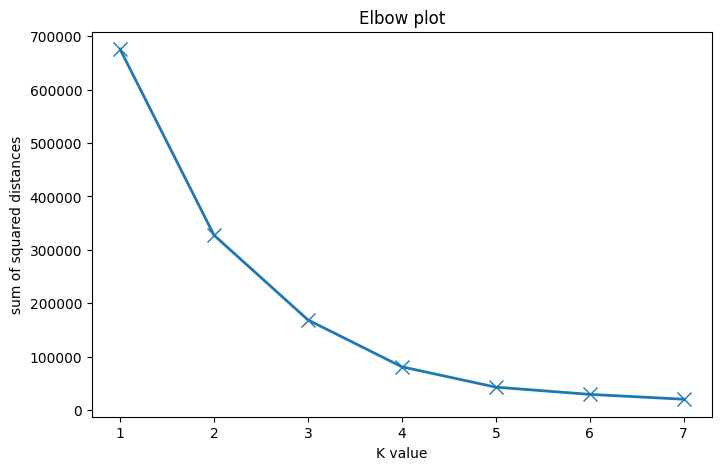

In [198]:
#find optimium clusters
distances = []
K = range(1,8)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(shap_embedded)
    distances.append(km.inertia_)
    
plt.figure(figsize=(8,5))
plt.plot(np.arange(1,8),distances,marker='x',linewidth=2,markersize=10)
plt.title('Elbow plot')
plt.xlabel('K value')
plt.ylabel('sum of squared distances')
plt.show()

In [199]:
km = KMeans(n_clusters=4,random_state=0)
km = km.fit(shap_embedded)
labels = km.labels_

In [200]:
color_dict = dict(zip(list(range(4)),sns.color_palette("hls", 6)))
colors = [color_dict[label] for label in labels]

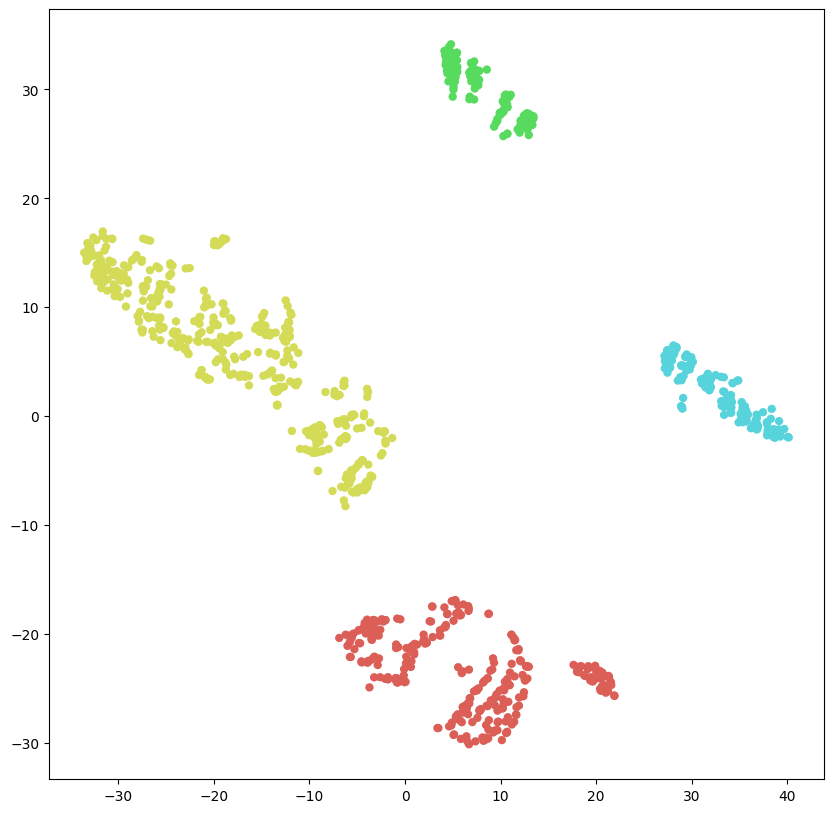

In [201]:
f = plt.figure(figsize=(10,10))
plt.scatter(shap_embedded[:,0],
           shap_embedded[:,1],
            c=colors,
           linewidth=0, alpha=1.)

plt.show()